In [1]:
!python --version
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
import librosa
import librosa.display
import noisereduce as nr
from scipy.io.wavfile import write
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.utils import shuffle
from sklearn.metrics import make_scorer
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from scipy.signal import find_peaks
from scipy.fft import fft
from scipy.stats import skew, kurtosis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Python 3.9.13


In [2]:
df_dev = pd.read_csv('./development.csv')
df_eval = pd.read_csv('./evaluation.csv')

# Adjust indices to start from 1
df_dev.index = pd.Index(range(1, len(df_dev) + 1))
df_eval.index = pd.Index(range(1, len(df_eval) + 1))

In [438]:
# df_dev.info(), df_eval.info()

# Preliminar analysis and Preprocessing

In [439]:
df_dev['sampling_rate'].unique()

array([22050], dtype=int64)

In [440]:
### Remove Id column
df_dev.drop(columns = ["Id"], inplace = True)
df_eval.drop(columns = ["Id"], inplace = True)

### Save the path
s_dev_path = df_dev.pop("path")
s_eval_path = df_eval.pop("path")

### Remove Sampling rate (all equal)
df_dev.drop(columns = ["sampling_rate"], inplace = True)
df_eval.drop(columns = ["sampling_rate"], inplace = True)

### Visualization

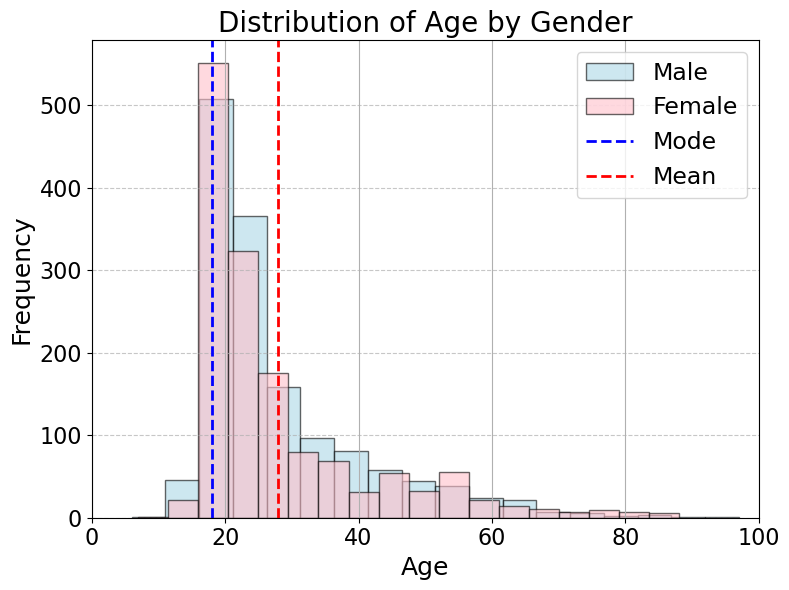

In [441]:
plt.figure(figsize=(8, 6))

df_dev[df_dev['gender'] == 'male']['age'].hist(alpha=0.6, color='lightblue', bins=18, label='Male', edgecolor='black')
df_dev[df_dev['gender'] == 'female']['age'].hist(alpha=0.6, color='pink', bins=18, label='Female', edgecolor='black')

plt.axvline(x=df_dev["age"].mode()[0], color='blue', linestyle='--', linewidth=2, label="Mode")
plt.axvline(x=df_dev["age"].mean(), color='red', linestyle='--', linewidth=2, label="Mean")

plt.title('Distribution of Age by Gender', fontsize=20)
plt.xlabel('Age', fontsize=18)
plt.ylabel('Frequency', fontsize=18)

plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.xlim(0, 100)
plt.tick_params(axis='both', labelsize=16)

plt.legend(fontsize=17, loc='upper right')

plt.tight_layout()
plt.show()

### Ethnicity

**Should we remove it?**

In [7]:
num_ethnicity_dev = df_dev['ethnicity'].nunique()  
num_ethnicity_eval = df_eval['ethnicity'].nunique()  

ethnicity_dev_set = set(df_dev['ethnicity'])  # Ethnicity in development
ethnicity_eval_set = set(df_eval['ethnicity'])  # Ethnicity in evalutaion

only_in_dev = ethnicity_dev_set - ethnicity_eval_set  # Ethnicity only in dev and not in eval
only_in_eval = ethnicity_eval_set - ethnicity_dev_set  # Ethnicity only in eval and not in dev

print(f"Num_ethnicity dev and eval: {num_ethnicity_dev, num_ethnicity_eval}")
print(f"Num only in dev and only in eval: {len(only_in_dev)}, {len(only_in_eval)}")

ethnicity_count_dev = df_dev['ethnicity'].value_counts().to_dict()
ethnicity_count_eval = df_eval['ethnicity'].value_counts().to_dict()

#print(ethnicity_count_dev)
#print(ethnicity_count_eval)

Num_ethnicity dev and eval: (165, 73)
Num only in dev and only in eval: 148, 56


Ethnicity proved to be a challenging feature, as it was not always present in both datasets and many ethnic groups had only one sample, potentially introducing bias. One-hot encoding would increase the number of sparse columns, with some ethnicities, like 'Igbo' and 'English', being overrepresented, while others were underrepresented. This imbalance could affect model generalization, as the model may favor more frequent groups. Additionally, the evaluation set contained some ethnicities not present in the development set, and vice versa. To address this, we grouped ethnicities into "macro groups" based on continents, manually in an external Excel file, for direct importation of segmented data.

In [8]:
### Removing ethnicity, will be added later
df_dev.pop("ethnicity");
df_eval.pop("ethnicity");

### Some removals and conversions

In [9]:
### Gender from male, female to 1,0
df_dev['gender'] = df_dev['gender'].str[0].map({'f': int(0), 'm': int(1)})
df_eval['gender'] = df_eval['gender'].str[0].map({'f': int(0), 'm': int(1)})


### Extract tempo number
df_dev['tempo'] = df_dev['tempo'].apply(lambda x: float(x[1:-1]))
df_eval['tempo'] = df_eval['tempo'].apply(lambda x: float(x[1:-1]))


### Remove label
y_dev = df_dev.pop("age")

In [10]:
#df_dev.head()

In [11]:
#df_eval.head()

## Audio clearning

### (1) Removal of 0.0 samples at the beginning and at the end

In [14]:
def trim_zeros(signal):
    nonzero_indices = np.where(np.abs(signal) > 10**(-10))[0]   
    #print(len(signal),len(nonzero_indices))
    if len(nonzero_indices) > 0:
        start, end = nonzero_indices[0], nonzero_indices[-1]    # First and last non-zero element
        return signal[start:end + 1]
    else:
        return signal

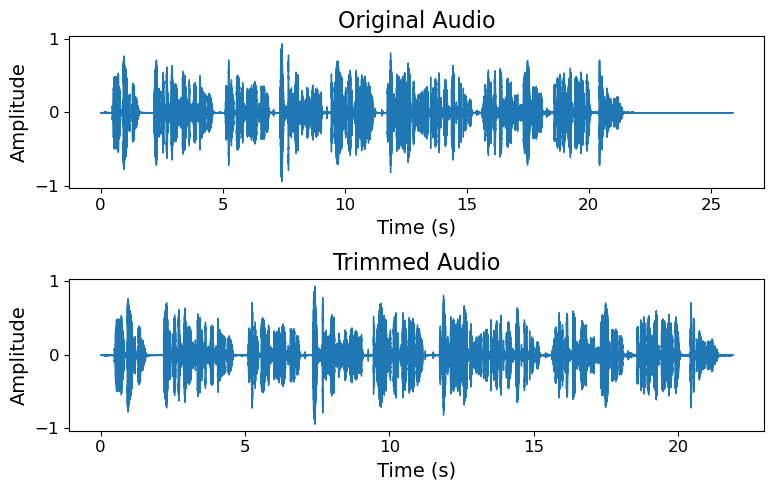

In [28]:
### EXAMPLE (audio 623)
audio_location = "C:\\Documenti\\Desktop\\project2025\\DSL_Winter_Project_2025\\audios_development\\623.wav"

audio, sr = librosa.load(audio_location, sr=None)
audio_trimmed = trim_zeros(audio)

fig, axes = plt.subplots(2, 1, figsize=(8, 5))
librosa.display.waveshow(audio, sr=sr, ax=axes[0])
axes[0].set_title("Original Audio", fontsize=16)
axes[0].set_xlabel("Time (s)", fontsize=14)
axes[0].set_ylabel("Amplitude", fontsize=14)
axes[0].tick_params(axis='both', labelsize=12)

librosa.display.waveshow(audio_trimmed, sr=sr, ax=axes[1])
axes[1].set_title("Trimmed Audio", fontsize=16)
axes[1].set_xlabel("Time (s)", fontsize=14)
axes[1].set_ylabel("Amplitude", fontsize=14)
axes[1].tick_params(axis='both', labelsize=12)


plt.tight_layout()
plt.show()

In [91]:
input_dir_dev = "C:\\Documenti\\Desktop\\project2025\\DSL_Winter_Project_2025\\audios_development\\"
output_dir_dev = "C:\\Documenti\\Desktop\\project2025\\DSL_Winter_Project_2025\\trimmed_audios_dev\\"

for i in range(1, df_dev.shape[0]+1):  
    file_path = os.path.join(input_dir_dev, f"{i}.wav")
    if os.path.exists(file_path):
        audio, sr = librosa.load(file_path, sr=None)
        audio_trimmed = trim_zeros(audio)
        audio_trimmed_norm = np.int16(audio_trimmed / np.max(np.abs(audio_trimmed)) * 32767)    # Normalize to prevent clipping
        
        output_file_path = os.path.join(output_dir_dev, f"{i}_tr_dev.wav")
        write(output_file_path, sr, audio_trimmed_norm)
    else:
        print(f"File {file_path} not found.")

In [92]:
input_dir_eval = "C:\\Documenti\\Desktop\\project2025\\DSL_Winter_Project_2025\\audios_evaluation\\"
output_dir_eval = "C:\\Documenti\\Desktop\\project2025\\DSL_Winter_Project_2025\\trimmed_audios_eval\\"

for i in range(1, df_eval.shape[0]+1):  
    file_path = os.path.join(input_dir_eval, f"{i}.wav")
    if os.path.exists(file_path):
        audio, sr = librosa.load(file_path, sr=None)
        audio_trimmed = trim_zeros(audio)
        audio_trimmed_norm = np.int16(audio_trimmed / np.max(np.abs(audio_trimmed)) * 32767)    # Normalize to prevent clipping

        output_file_path = os.path.join(output_dir_eval, f"{i}_tr_eval.wav")
        write(output_file_path, sr, audio_trimmed_norm)
    else:
        print(f"File {file_path} not found.")

### (2) Denoising

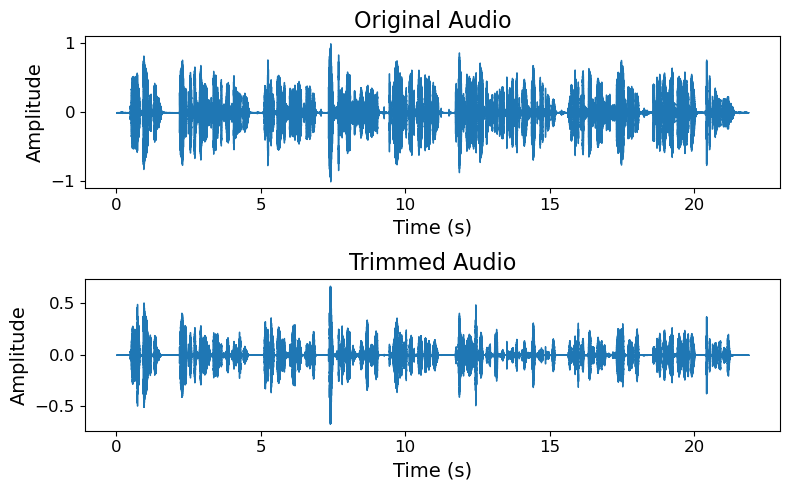

In [24]:
### EXAMPLE (audio 623)
audio_location = "C:\\Documenti\\Desktop\\project2025\\DSL_Winter_Project_2025\\trimmed_audios_dev\\623_tr_dev.wav"

audio, sr = librosa.load(audio_location, sr=None)
noise_profile = audio[:sr]  
audio_denoised = nr.reduce_noise(y=audio, sr=sr, y_noise=noise_profile)

fig, axes = plt.subplots(2, 1, figsize=(8, 5))
librosa.display.waveshow(audio, sr=sr, ax=axes[0])
axes[0].set_title("Original Audio", fontsize=16)
axes[0].set_xlabel("Time (s)", fontsize=14)
axes[0].set_ylabel("Amplitude", fontsize=14)
axes[0].tick_params(axis='both', labelsize=12)

librosa.display.waveshow(audio_denoised, sr=sr, ax=axes[1])
axes[1].set_title("Trimmed Audio", fontsize=16)
axes[1].set_xlabel("Time (s)", fontsize=14)
axes[1].set_ylabel("Amplitude", fontsize=14)
axes[1].tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()

In [94]:
input_dir = "C:\\Documenti\\Desktop\\project2025\\DSL_Winter_Project_2025\\trimmed_audios_dev\\"
output_dir = "C:\\Documenti\\Desktop\\project2025\\DSL_Winter_Project_2025\\denoised_audios_dev\\"

for i in range(1, df_dev.shape[0]+1):  
    file_path = os.path.join(input_dir, f"{i}_tr_dev.wav")
    
    if os.path.exists(file_path):
        audio, sr = librosa.load(file_path, sr=None)
        
        noise_profile = audio[:sr]
        audio_denoised = nr.reduce_noise(y=audio, sr=sr, y_noise=noise_profile)
        
        audio_denoised_normalized = np.int16(audio_denoised / np.max(np.abs(audio_denoised)) * 32767)   # to prevent clipping

        output_file_path = os.path.join(output_dir, f"{i}_den_dev.wav")
        write(output_file_path, sr, audio_denoised_normalized)

    else:
        print(f"File {file_path} not found.")

In [95]:
input_dir = "C:\\Documenti\\Desktop\\project2025\\DSL_Winter_Project_2025\\trimmed_audios_eval\\"
output_dir = "C:\\Documenti\\Desktop\\project2025\\DSL_Winter_Project_2025\\denoised_audios_eval\\"

for i in range(1, df_eval.shape[0]+1): 
    file_path = os.path.join(input_dir, f"{i}_tr_eval.wav")
    
    if os.path.exists(file_path):
        audio, sr = librosa.load(file_path, sr=None)
        
        # Denoise the audio
        noise_profile = audio[:sr]  # First second of the audio as noise profile
        audio_denoised = nr.reduce_noise(y=audio, sr=sr, y_noise=noise_profile)
        
        audio_denoised_normalized = np.int16(audio_denoised / np.max(np.abs(audio_denoised)) * 32767)     # to prevent clipping

        output_file_path = os.path.join(output_dir, f"{i}_den_eval.wav")
        write(output_file_path, sr, audio_denoised_normalized)
    else:
        print(f"File {file_path} not found.")

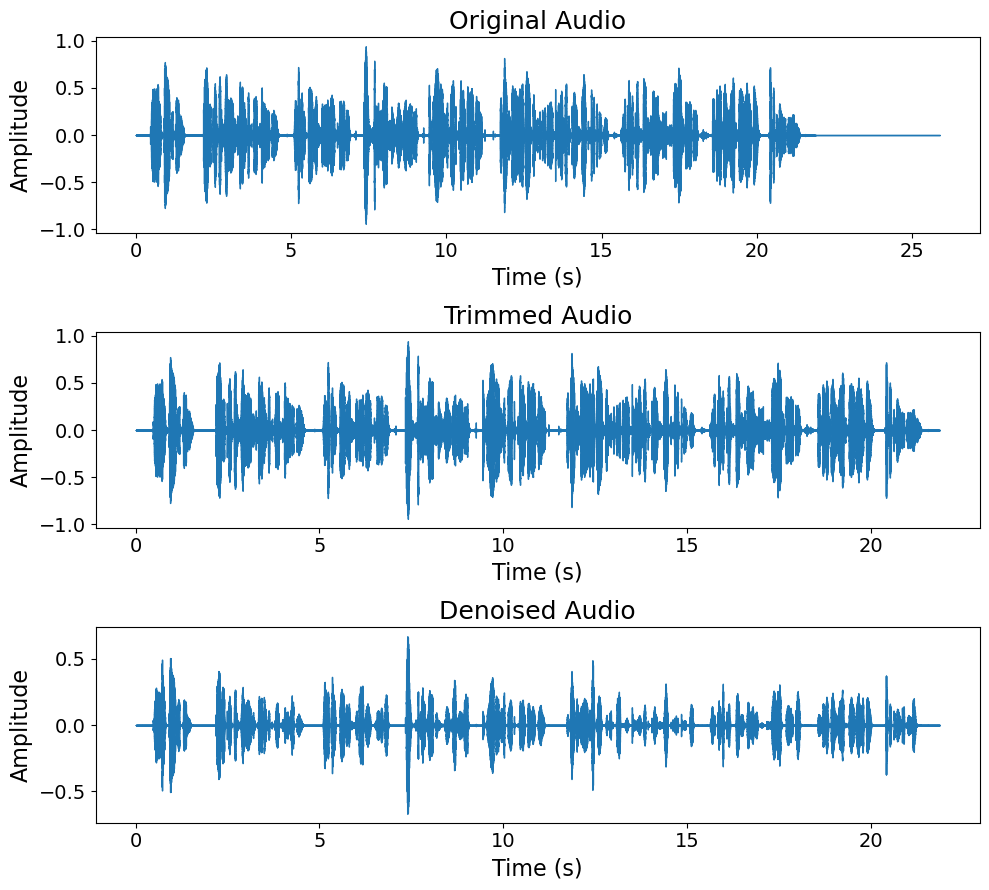

In [30]:
fig, axes = plt.subplots(3, 1, figsize=(10, 9))

librosa.display.waveshow(audio, sr=sr, ax=axes[0])
axes[0].set_title("Original Audio", fontsize=18)
axes[0].set_xlabel("Time (s)", fontsize=16)
axes[0].set_ylabel("Amplitude", fontsize=16)
axes[0].tick_params(axis='both', labelsize=14)

librosa.display.waveshow(audio_trimmed, sr=sr, ax=axes[1])
axes[1].set_title("Trimmed Audio", fontsize=18)
axes[1].set_xlabel("Time (s)", fontsize=16)
axes[1].set_ylabel("Amplitude", fontsize=16)
axes[1].tick_params(axis='both', labelsize=14)

librosa.display.waveshow(audio_denoised, sr=sr, ax=axes[2])
axes[2].set_title("Denoised Audio", fontsize=18)
axes[2].set_xlabel("Time (s)", fontsize=16)
axes[2].set_ylabel("Amplitude", fontsize=16)
axes[2].tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.show()

# Features extraction and rielaboration

In [9]:
def spectral_bandwidth_f(signal):
    S = librosa.stft(signal)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(S=np.abs(S))
    return np.mean(spectral_bandwidth)


def energy_f(signal, frame_length=2048, hop_length=512):
    S = librosa.stft(signal, n_fft=frame_length, hop_length=hop_length)
    energy = np.sum(np.abs(S) ** 2, axis=0)
    return energy


def delta_energy_f(energy):     # How much the energy changes from one frame to the next.
    delta_energy = np.diff(energy)
    return delta_energy


def formants_3_f(signal,  sampl_rate, n_fft = 2048, hop_length = 512):
    S = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    freqs = librosa.fft_frequencies(n_fft=n_fft)
    
    spectral_envelope = np.mean(S, axis=1)
    

    peaks, _ = find_peaks(spectral_envelope, height=-50, distance=10)     
    
    peak_freqs = freqs[peaks]
    peak_magnitudes = spectral_envelope[peaks]
    
    sorted_indices = np.argsort(peak_magnitudes)[::-1]
    formant_freqs = peak_freqs[sorted_indices][:3]    #First 3 formants
    
    while len(formant_freqs) < 3:     #Edge cases with less formants
        formant_freqs = np.append(formant_freqs, 0)
    return formant_freqs



def spectral_skewness_kurtosis_f(signal):
    spectrum = np.abs(fft(signal))

    spectral_skewness = skew(spectrum)
    spectral_kurtosis = kurtosis(spectrum)

    return spectral_skewness, spectral_kurtosis


def log_scaled_band_energy_f(signal):        
    S = librosa.stft(signal)
    magnitude = np.abs(S)
    mel_frequencies = librosa.mel_frequencies(n_mels=10, fmin=20, fmax=sr // 2)   # Compute the logarithmic scale frequencies (10 bands)
    
    energies = []    
    for i in range(len(mel_frequencies) - 1):
        freq_min = mel_frequencies[i]
        freq_max = mel_frequencies[i + 1]
        
        idx_min = np.searchsorted(librosa.fft_frequencies(sr=sr), freq_min)
        idx_max = np.searchsorted(librosa.fft_frequencies(sr=sr), freq_max)
        band_energy = np.sum(magnitude[idx_min:idx_max, :]**2)
        energies.append(band_energy)
    
    total_energy = np.sum(magnitude**2)   
    normalized_energies = np.array(energies) / total_energy    # Normalization
    
    return normalized_energies




def frequency_median_f(signal, sampling_rate):
    S = librosa.stft(signal)  
    magnitude = np.abs(S)  
    energy = magnitude**2
    total_energy = np.sum(energy, axis=1)  # Total energy for each frequency
    total_energy_signal = np.sum(total_energy)
    cumulative_energy = np.cumsum(total_energy) / total_energy_signal    # Calculate the cumulative energy and normalization
    median_index = np.searchsorted(cumulative_energy, 0.5)    # Find the frequency that corresponds to 50% of the cumulative energy
    median_frequency = librosa.fft_frequencies(sr=sampling_rate)[median_index]

    return median_frequency




def mfcc_f(audio, sr, nn = 13):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=nn)
    mfcc_mean = np.mean(mfcc, axis=1)
    #mfcc_std = np.std(mfcc, axis=1)

    return mfcc_mean   #, mfcc_std



def delta_derivative_percentiles_f(signal, percentiles=[10, 25, 50, 75, 90]):
    signal_derivative = np.diff(signal)  # First derivative of the raw signal
    percentiles_values = np.percentile(signal_derivative, percentiles)
    
    return percentiles_values

### Duration and Bandwidth

In [14]:
input_dir_dev = "C:\\Documenti\\Desktop\\project2025\\DSL_Winter_Project_2025\\denoised_audios_dev\\"
input_dir_eval = "C:\\Documenti\\Desktop\\project2025\\DSL_Winter_Project_2025\\denoised_audios_eval\\"


for i in range(1,df_dev.shape[0]+1): 
    file_path = os.path.join(input_dir_dev, f"{i}_den_dev.wav") 

    if os.path.exists(file_path):
        audio, sr = librosa.load(file_path, sr=None)  
        duration = len(audio) / sr 
        df_dev.at[i, 'duration'] = duration  
        
        spectral_bandwidth = spectral_bandwidth_f(audio)
        df_dev.at[i, 'spectral_bandwidth'] = spectral_bandwidth
    else:
        print(f"File not found: {file_path}")
        
        
        
for i in range(1,df_eval.shape[0]+1): 
    file_path = os.path.join(input_dir_eval, f"{i}_den_eval.wav") 

    if os.path.exists(file_path):
        audio, sr = librosa.load(file_path, sr=None)  
        duration = len(audio) / sr 
        df_eval.at[i, 'duration'] = duration  
        
        spectral_bandwidth = spectral_bandwidth_f(audio)
        df_eval.at[i, 'spectral_bandwidth'] = spectral_bandwidth   
    else:
        print(f"File not found: {file_path}")

### Delta energy

In [15]:
input_dir_dev = "C:\\Documenti\\Desktop\\project2025\\DSL_Winter_Project_2025\\denoised_audios_dev\\"
input_dir_eval = "C:\\Documenti\\Desktop\\project2025\\DSL_Winter_Project_2025\\denoised_audios_eval\\"


for i in range(1,df_dev.shape[0]+1): 
    file_path = os.path.join(input_dir_dev, f"{i}_den_dev.wav") 

    if os.path.exists(file_path):
        audio, sr = librosa.load(file_path, sr=None)  
        
        energy = energy_f(audio)
        df_dev.at[i, 'energy_new'] = energy.mean()
        
        delta_energy = delta_energy_f(energy)
        df_dev.at[i, 'delta_energy'] = delta_energy.mean()
    else:
        print(f"File not found: {file_path}")
        
        
        
for i in range(1,df_eval.shape[0]+1): 
    file_path = os.path.join(input_dir_eval, f"{i}_den_eval.wav") 

    if os.path.exists(file_path):
        audio, sr = librosa.load(file_path, sr=None)  
        
        energy = energy_f(audio) 
        df_eval.at[i, 'energy_new'] = energy.mean() 
        
        delta_energy = delta_energy_f(energy)
        df_eval.at[i, 'delta_energy'] = delta_energy.mean()   
    else:
        print(f"File not found: {file_path}")

### Formants (F1, F2, F3)

In [17]:
input_dir_dev = "C:\\Documenti\\Desktop\\project2025\\DSL_Winter_Project_2025\\denoised_audios_dev\\"
input_dir_eval = "C:\\Documenti\\Desktop\\project2025\\DSL_Winter_Project_2025\\denoised_audios_eval\\"

def check_clipping(audio, threshold=0.99):
    clipped_samples = np.sum(np.abs(audio) >= threshold)
    total_samples = len(audio)
    clipping_percentage = (clipped_samples / total_samples) * 100
    return clipped_samples, clipping_percentage



for i in range(1,df_dev.shape[0]+1): 
    file_path = os.path.join(input_dir_dev, f"{i}_den_dev.wav") 


    if os.path.exists(file_path):
        audio, sr = librosa.load(file_path, sr=None)  
        
        ### Check
        clipped_samples, clipping_percentage = check_clipping(audio)
        #print(f"Clipped samples: {clipped_samples}")
        #print(f"Percentage of clipping: {clipping_percentage:.2f}%")
        
        f1, f2, f3 = formants_3_f(audio, sr)
        df_dev.at[i, 'f1'] = f1
        df_dev.at[i, 'f2'] = f2
        df_dev.at[i, 'f3'] = f3
    else:
        print(f"File not found: {file_path}")
        
        
        
for i in range(1,df_eval.shape[0]+1): 
    file_path = os.path.join(input_dir_eval, f"{i}_den_eval.wav") 

    if os.path.exists(file_path):
        audio, sr = librosa.load(file_path, sr=None)  
        
        f1, f2, f3 = formants_3_f(audio, sr)
        df_eval.at[i, 'f1'] = f1
        df_eval.at[i, 'f2'] = f2
        df_eval.at[i, 'f3'] = f3  
    else:
        print(f"File not found: {file_path}")

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


### Skewness and Kurtosis

In [18]:
input_dir_dev = "C:\\Documenti\\Desktop\\project2025\\DSL_Winter_Project_2025\\denoised_audios_dev\\"
input_dir_eval = "C:\\Documenti\\Desktop\\project2025\\DSL_Winter_Project_2025\\denoised_audios_eval\\"


for i in range(1,df_dev.shape[0]+1): 
    file_path = os.path.join(input_dir_dev, f"{i}_den_dev.wav") 

    if os.path.exists(file_path):
        audio, sr = librosa.load(file_path, sr=None)  
        skw, kurt = spectral_skewness_kurtosis_f(audio)
        df_dev.at[i, 'skewness'] = skw
        df_dev.at[i, 'kurtosis'] = kurt
    else:
        print(f"File not found: {file_path}")
        
        
        
for i in range(1,df_eval.shape[0]+1): 
    file_path = os.path.join(input_dir_eval, f"{i}_den_eval.wav") 

    if os.path.exists(file_path):
        audio, sr = librosa.load(file_path, sr=None)  
        skw, kurt = spectral_skewness_kurtosis_f(audio)
        df_eval.at[i, 'skewness'] = skw
        df_eval.at[i, 'kurtosis'] = kurt
    else:
        print(f"File not found: {file_path}")

### % of energy => 10 slots, 9 features

In [20]:
input_dir_dev = "C:\\Documenti\\Desktop\\project2025\\DSL_Winter_Project_2025\\denoised_audios_dev\\"
input_dir_eval = "C:\\Documenti\\Desktop\\project2025\\DSL_Winter_Project_2025\\denoised_audios_eval\\"


for i in range(1,df_dev.shape[0]+1): 
    file_path = os.path.join(input_dir_dev, f"{i}_den_dev.wav") 

    if os.path.exists(file_path):
        audio, sr = librosa.load(file_path, sr=None)  
        ten_f = log_scaled_band_energy_f(audio)
        for j, t in enumerate(ten_f):
            df_dev.at[i, f'e{j}'] = t
    else:
        print(f"File not found: {file_path}")
        
        
        
for i in range(1,df_eval.shape[0]+1): 
    file_path = os.path.join(input_dir_eval, f"{i}_den_eval.wav") 

    if os.path.exists(file_path):
        audio, sr = librosa.load(file_path, sr=None)  
        ten_f = log_scaled_band_energy_f(audio)
        for j, t in enumerate(ten_f):
            df_eval.at[i, f'e{j}'] = t
    else:
        print(f"File not found: {file_path}")

### Median frequence

In [21]:
input_dir_dev = "C:\\Documenti\\Desktop\\project2025\\DSL_Winter_Project_2025\\denoised_audios_dev\\"
input_dir_eval = "C:\\Documenti\\Desktop\\project2025\\DSL_Winter_Project_2025\\denoised_audios_eval\\"


for i in range(1,df_dev.shape[0]+1): 
    file_path = os.path.join(input_dir_dev, f"{i}_den_dev.wav") 

    if os.path.exists(file_path):
        audio, sr = librosa.load(file_path, sr=None)  
        median = frequency_median_f(audio, sr)
        df_dev.at[i, 'median'] = median  
    else:
        print(f"File not found: {file_path}")
        
        
        
for i in range(1,df_eval.shape[0]+1): 
    file_path = os.path.join(input_dir_eval, f"{i}_den_eval.wav") 

    if os.path.exists(file_path):
        audio, sr = librosa.load(file_path, sr=None)  
        median =  frequency_median_f(audio, sr) 
        df_eval.at[i, 'median'] = median   
    else:
        print(f"File not found: {file_path}")

### MFCC 

In [24]:
input_dir_dev = "C:\\Documenti\\Desktop\\project2025\\DSL_Winter_Project_2025\\denoised_audios_dev\\"
input_dir_eval = "C:\\Documenti\\Desktop\\project2025\\DSL_Winter_Project_2025\\denoised_audios_eval\\"


nn = 13 

for i in range(1,df_dev.shape[0]+1): 
    file_path = os.path.join(input_dir_dev, f"{i}_den_dev.wav") 

    if os.path.exists(file_path):
        audio, sr = librosa.load(file_path, sr=None)  
        mfcc_mean = mfcc_f(audio, sr, nn)
        
        for j, m_mean in enumerate(mfcc_mean):
            df_dev.at[i, f'mfcc_mean_{j}'] = m_mean
    else:
        print(f"File not found: {file_path}")
        
        
        
for i in range(1,df_eval.shape[0]+1): 
    file_path = os.path.join(input_dir_eval, f"{i}_den_eval.wav") 

    if os.path.exists(file_path):
        audio, sr = librosa.load(file_path, sr=None)  
        mfcc_mean = mfcc_f(audio, sr, nn)
        
        for j, c_mean in enumerate(mfcc_mean):
            df_eval.at[i, f'mfcc_mean_{j}'] = c_mean
    else:
        print(f"File not found: {file_path}")

### Percentiles of the derivative (of the raw signal)

In [25]:
input_dir_dev = "C:\\Documenti\\Desktop\\project2025\\DSL_Winter_Project_2025\\denoised_audios_dev\\"
input_dir_eval = "C:\\Documenti\\Desktop\\project2025\\DSL_Winter_Project_2025\\denoised_audios_eval\\"


for i in range(1,df_dev.shape[0]+1): 
    file_path = os.path.join(input_dir_dev, f"{i}_den_dev.wav") 

    if os.path.exists(file_path):
        audio, sr = librosa.load(file_path, sr=None)  
        ten_d = delta_derivative_percentiles_f(audio)
        for j, d in enumerate(ten_d):
            df_dev.at[i, f'd{j}'] = d
    else:
        print(f"File not found: {file_path}")
        
        
        
for i in range(1,df_eval.shape[0]+1): 
    file_path = os.path.join(input_dir_eval, f"{i}_den_eval.wav") 

    if os.path.exists(file_path):
        audio, sr = librosa.load(file_path, sr=None)  
        ten_d = delta_derivative_percentiles_f(audio)
        for j, d in enumerate(ten_d):
            df_eval.at[i, f'd{j}'] = d
    else:
        print(f"File not found: {file_path}")

### Normalization

We rework/substitute the following features (so they become more comparable across different samples) <br>
- energy_new / duration (as the energy new is the total energy of the entire signal)
- num_words / duration
- num_char / duration
- num_pauese / duration
- silence_duration / duration

In [26]:
col_to_divide = ["num_words", "num_characters", "num_pauses", "silence_duration", 'energy_new']
for col in col_to_divide:
    df_dev[col] /= df_dev['duration']
    df_eval[col] /= df_eval['duration']

### Ethnicity

In [40]:
# dev_eth = pd.read_csv('dev_eth.csv')
# eval_eth = pd.read_csv('eval_eth.csv')

# dev_eth.index = dev_eth.index + 1
# eval_eth.index = eval_eth.index + 1

# df_dev = pd.concat([df_dev, dev_eth], axis=1)
# df_eval = pd.concat([df_eval, eval_eth], axis=1)

In [489]:
# df_dev.to_csv('df_dev_FINAL.csv')
# df_eval.to_csv('df_eval_FINAL.csv')

# y_dev.to_csv("y_dev.csv")

In [41]:
# df_dev.to_csv('df_dev_FINAL_new.csv')
# df_eval.to_csv('df_eval_FINAL_new.csv')

# y_dev.to_csv("y_dev.csv")

**IMPORTING PREVIOUSLY CREATED FEATURES:**

In [27]:
# df_dev = pd.read_csv('df_dev_FINAL_new.csv',  index_col=0)
# df_eval = pd.read_csv('df_eval_FINAL_new.csv',  index_col=0)
# y_dev = pd.read_csv('y_dev.csv',  index_col=0)

In [26]:
# df_dev.info()

# Correlation

### Words, pauses, characters, silence, duration

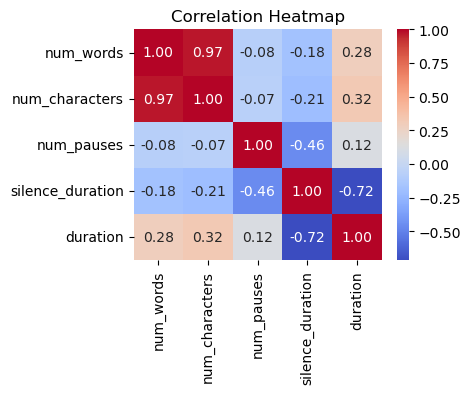

In [37]:
selected_columns = ['num_words', 'num_characters', 'num_pauses', 'silence_duration', 'duration']
correlation_matrix = df_dev[selected_columns].corr()

plt.figure(figsize=(4, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

**num_characters** could be remooved.

### Pitch

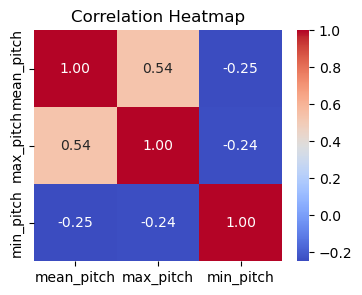

In [39]:
selected_columns = ['mean_pitch', 'max_pitch', 'min_pitch']
correlation_matrix = df_dev[selected_columns].corr()

plt.figure(figsize=(4, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

We can keep all 3 features as 0.54 is not enough high.

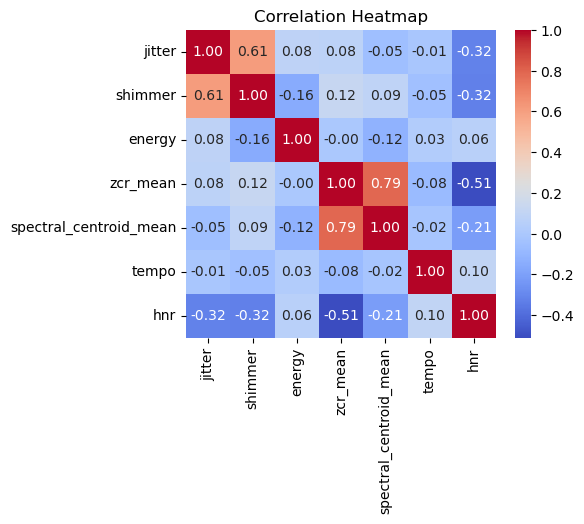

In [40]:
selected_columns = ['jitter', 'shimmer', 'energy', 'zcr_mean', 'spectral_centroid_mean', 'tempo', 'hnr']
correlation_matrix = df_dev[selected_columns].corr()

plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

0.61 is still not enough to discard one of the 2 features.  Maybe 0.79.

### f1, f2, f3

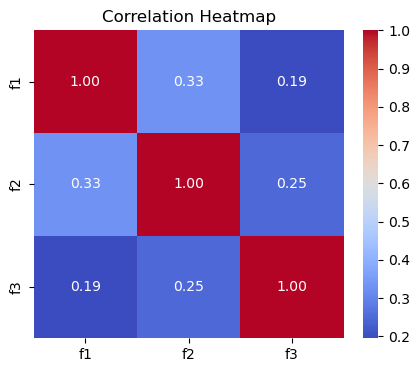

In [41]:
selected_columns = ['f1', 'f2', 'f3']
correlation_matrix = df_dev[selected_columns].corr()

plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

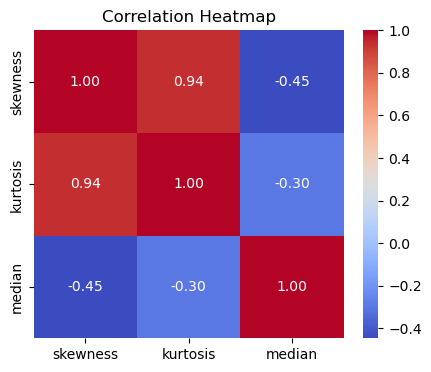

In [42]:
selected_columns = ['skewness', 'kurtosis', 'median']
correlation_matrix = df_dev[selected_columns].corr()

plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

We should keep or skewness or kurtosis, or we could sum or multiply them.  **DECIDED LATER** 

### e_i

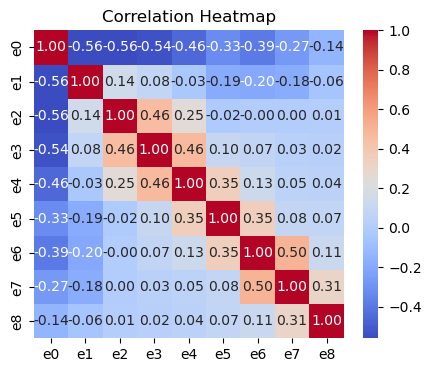

In [43]:
selected_columns = ['e0', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8']
correlation_matrix = df_dev[selected_columns].corr()

plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# MFCC

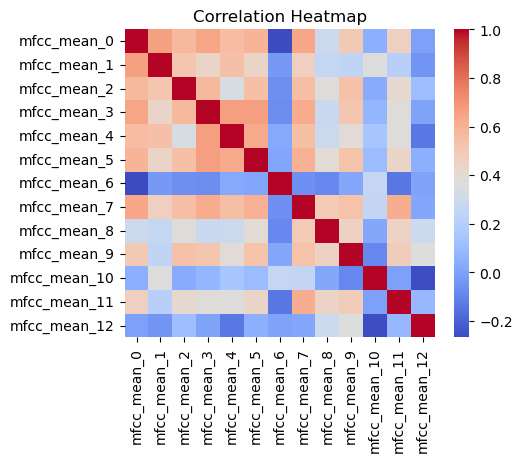

In [44]:
selected_columns = [f'mfcc_mean_{i}' for i in range(13)]
correlation_matrix = df_dev[selected_columns].corr()
mask = (correlation_matrix > 0.79) | (correlation_matrix < -0.79)

plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

### DERIVATIVE of the RAW SIGNALS

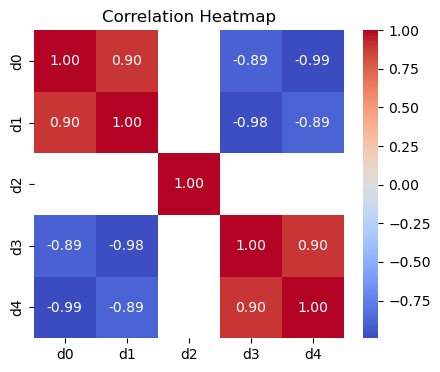

In [45]:
selected_columns = ['d0', 'd1', 'd2', 'd3', 'd4']
correlation_matrix = df_dev[selected_columns].corr()
mask = (correlation_matrix > 0.79) | (correlation_matrix < -0.79)

plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, mask = ~mask, annot = True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

d are all very correlated => It might be enough to keep d2, which is the 50% percentile.

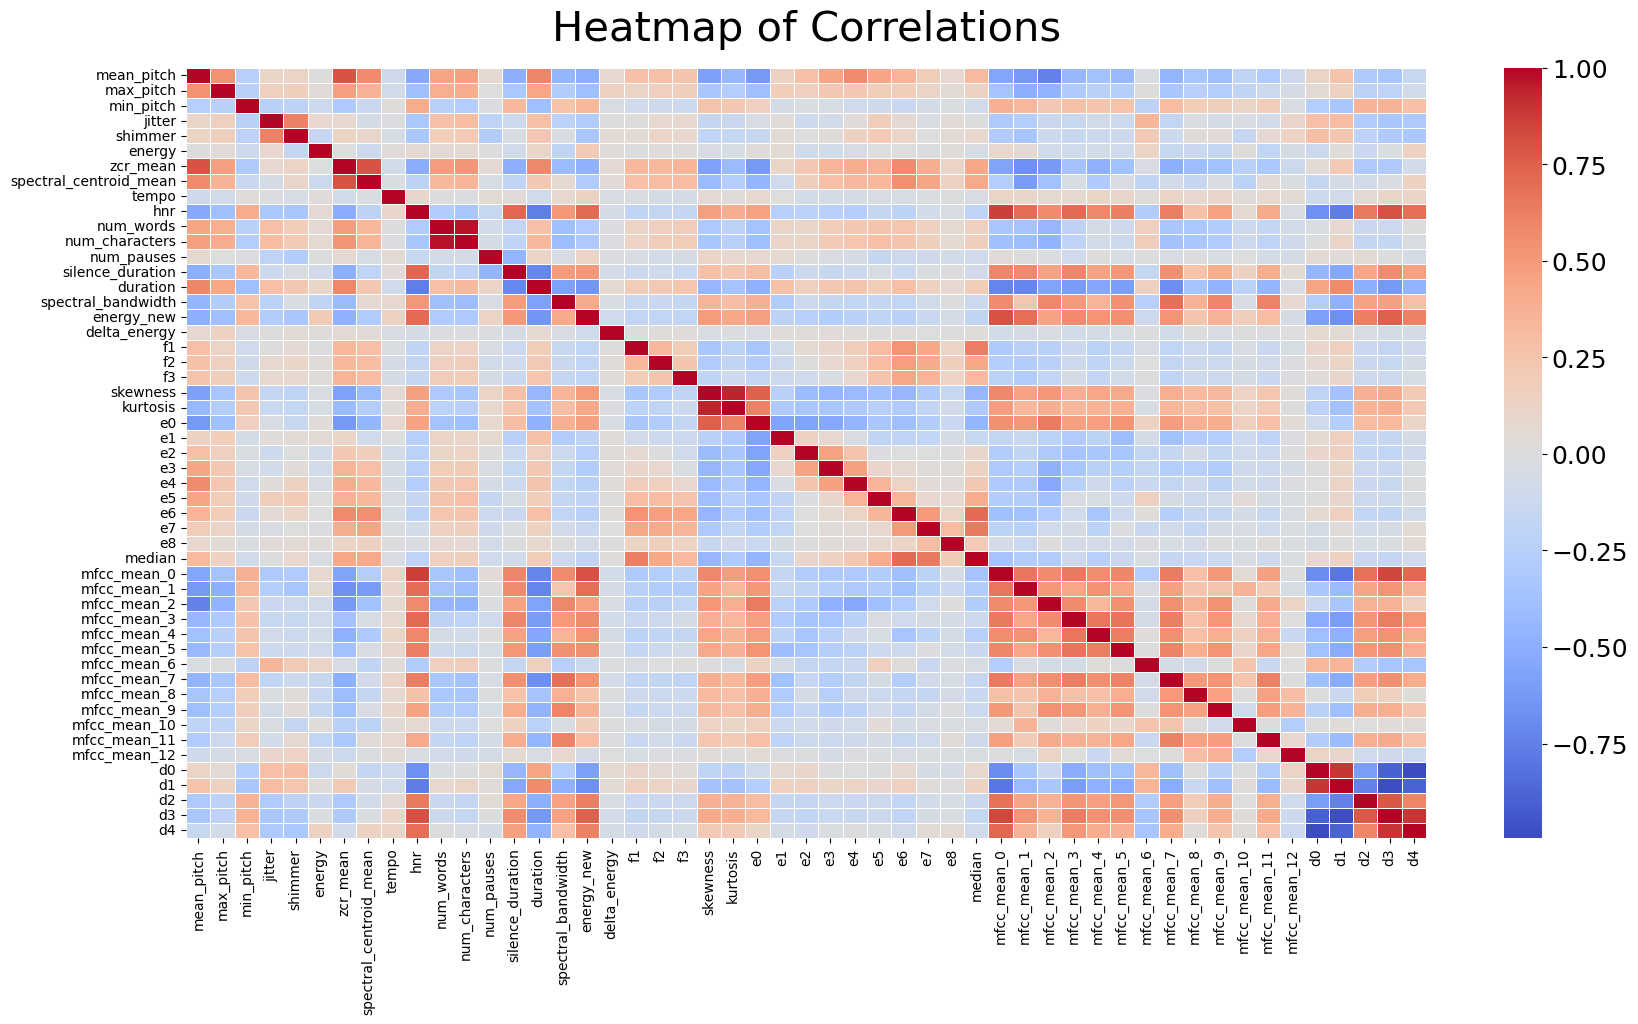

In [58]:
selected_columns = ['gender', 'Western', 'SubSaharian', 'Asian', 'Others'] 
correlation_matrix = df_dev.drop(columns=selected_columns).corr()

mask = (correlation_matrix > 0.) | (correlation_matrix < -0.)   #only correlated features

plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, mask=~mask, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)

colorbar = plt.gca().collections[0].colorbar
colorbar.ax.tick_params(labelsize=18)
plt.title('Heatmap of Correlations', fontsize=30, pad=20)
plt.show()

Wheter to keep zcr_mean or not will be decided later. As skewness is a bit correlated with e0 too => we might remove skewness and keep kurtisis!

In [27]:
# spearman_corr_matrix = df_dev.corr(method='spearman')
# mask = (spearman_corr_matrix > 0.79) | (spearman_corr_matrix < -0.79)

# plt.figure(figsize=(9, 7))
# sns.heatmap(spearman_corr_matrix, mask = ~mask, cmap='coolwarm', fmt='.2f')
# plt.title('Correlation Heatmap')
# plt.show()

We obtain similar results. 

# Outlier (visual) detection

To dectect anomalities in the values.

**%%capture**   to avoid prints

In [45]:
def find_extreme_indices_and_values(dataframe, features):
    extremes = {}
    for feature in features:
        max_idx = dataframe[feature].idxmax()  # Index of maximum value
        min_idx = dataframe[feature].idxmin()  # Index of minimum value
        mean_value = dataframe[feature].mean()  # Mean value
        extremes[feature] = {
            'max': {'index': max_idx, 'value': dataframe.loc[max_idx, feature]},
            'min': {'index': min_idx, 'value': dataframe.loc[min_idx, feature]},
            'mean': mean_value
        }
    return extremes

### mean_pitch, min_pitch, max_pitch

In [43]:
%%capture

plt.figure(figsize=(8, 4))

feature = 'mean_pitch'
yy = 200

df_dev_gender0 = df_dev[df_dev['gender'] == 0]
df_dev_gender1 = df_dev[df_dev['gender'] == 1]
df_eval_gender0 = df_eval[df_eval['gender'] == 0]
df_eval_gender1 = df_eval[df_eval['gender'] == 1]

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

axes[0].hist(df_dev_gender0[feature], alpha=0.8, color='lightyellow', bins=18, label='Dev Gender 0', edgecolor='pink')
axes[0].hist(df_eval_gender0[feature], alpha=0.8, color='lightgreen', bins=18, label='Eval Gender 0', edgecolor='pink')
axes[0].vlines(x=df_dev_gender0[feature].mean(), ymin=0, ymax=yy, color='pink', linestyle='dashed', label="Dev Gender 0 Mean")
axes[0].vlines(x=df_eval_gender0[feature].mean(), ymin=0, ymax=yy, color='pink', linestyle='solid', label="Eval Gender 0 Mean")
axes[0].set_title("Gender 0", fontsize=15)
axes[0].set_ylabel("Frequency", fontsize=13)
axes[0].set_xlabel("Feature", fontsize=13)
axes[0].tick_params(axis='both', labelsize=12)
axes[0].legend(fontsize=11)

axes[1].hist(df_dev_gender1[feature], alpha=0.8, color='lightyellow', bins=18, label='Dev Gender 1', edgecolor='lightblue')
axes[1].hist(df_eval_gender1[feature], alpha=0.8, color='lightgreen', bins=18, label='Eval Gender 1', edgecolor='lightblue')
axes[1].vlines(x=df_dev_gender1[feature].mean(), ymin=0, ymax=yy, color='lightblue', linestyle='dashed', label="Dev Gender 1 Mean")
axes[1].vlines(x=df_eval_gender1[feature].mean(), ymin=0, ymax=yy, color='lightblue', linestyle='solid', label="Eval Gender 1 Mean")
axes[1].set_title("Gender 1", fontsize=15)
axes[1].set_xlabel("Feature", fontsize=13)
axes[1].tick_params(axis='both', labelsize=12)
axes[1].legend(fontsize=11)

plt.tight_layout()
plt.show()


In [45]:
%%capture

plt.figure(figsize=(8, 4))

feature = 'min_pitch'
yy = 1200

df_dev_gender0 = df_dev[df_dev['gender'] == 0]
df_dev_gender1 = df_dev[df_dev['gender'] == 1]
df_eval_gender0 = df_eval[df_eval['gender'] == 0]
df_eval_gender1 = df_eval[df_eval['gender'] == 1]

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

axes[0].hist(df_dev_gender0[feature], alpha=0.8, color='lightyellow', bins=18, label='Dev Gender 0', edgecolor='pink')
axes[0].hist(df_eval_gender0[feature], alpha=0.8, color='lightgreen', bins=18, label='Eval Gender 0', edgecolor='pink')
axes[0].vlines(x=df_dev_gender0[feature].mean(), ymin=0, ymax=yy, color='pink', linestyle='dashed', label="Dev Gender 0 Mean")
axes[0].vlines(x=df_eval_gender0[feature].mean(), ymin=0, ymax=yy, color='pink', linestyle='solid', label="Eval Gender 0 Mean")
axes[0].set_title("Gender 0", fontsize=15)
axes[0].set_ylabel("Frequency", fontsize=13)
axes[0].set_xlabel("Feature", fontsize=13)
axes[0].tick_params(axis='both', labelsize=12)
axes[0].legend(fontsize=11)

axes[1].hist(df_dev_gender1[feature], alpha=0.8, color='lightyellow', bins=18, label='Dev Gender 1', edgecolor='lightblue')
axes[1].hist(df_eval_gender1[feature], alpha=0.8, color='lightgreen', bins=18, label='Eval Gender 1', edgecolor='lightblue')
axes[1].vlines(x=df_dev_gender1[feature].mean(), ymin=0, ymax=yy, color='lightblue', linestyle='dashed', label="Dev Gender 1 Mean")
axes[1].vlines(x=df_eval_gender1[feature].mean(), ymin=0, ymax=yy, color='lightblue', linestyle='solid', label="Eval Gender 1 Mean")
axes[1].set_title("Gender 1", fontsize=15)
axes[1].set_xlabel("Feature", fontsize=13)
axes[1].tick_params(axis='both', labelsize=12)
axes[1].legend(fontsize=11)

plt.tight_layout()
plt.show()


In [46]:
%%capture

plt.figure(figsize=(8, 4))

feature = 'max_pitch'
yy = 1200

df_dev_gender0 = df_dev[df_dev['gender'] == 0]
df_dev_gender1 = df_dev[df_dev['gender'] == 1]
df_eval_gender0 = df_eval[df_eval['gender'] == 0]
df_eval_gender1 = df_eval[df_eval['gender'] == 1]

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

axes[0].hist(df_dev_gender0[feature], alpha=0.8, color='lightyellow', bins=15, label='Dev Gender 0', edgecolor='pink')
axes[0].hist(df_eval_gender0[feature], alpha=0.8, color='lightgreen', bins=15, label='Eval Gender 0', edgecolor='pink')
axes[0].vlines(x=df_dev_gender0[feature].mean(), ymin=0, ymax=yy, color='pink', linestyle='dashed', label="Dev Gender 0 Mean")
axes[0].vlines(x=df_eval_gender0[feature].mean(), ymin=0, ymax=yy, color='pink', linestyle='solid', label="Eval Gender 0 Mean")
axes[0].set_title("Gender 0", fontsize=15)
axes[0].set_ylabel("Frequency", fontsize=13)
axes[0].set_xlabel("Feature", fontsize=13)
axes[0].tick_params(axis='both', labelsize=12)
axes[0].legend(fontsize=11)

axes[1].hist(df_dev_gender1[feature], alpha=0.8, color='lightyellow', bins=15, label='Dev Gender 1', edgecolor='lightblue')
axes[1].hist(df_eval_gender1[feature], alpha=0.8, color='lightgreen', bins=15, label='Eval Gender 1', edgecolor='lightblue')
axes[1].vlines(x=df_dev_gender1[feature].mean(), ymin=0, ymax=yy, color='lightblue', linestyle='dashed', label="Dev Gender 1 Mean")
axes[1].vlines(x=df_eval_gender1[feature].mean(), ymin=0, ymax=yy, color='lightblue', linestyle='solid', label="Eval Gender 1 Mean")
axes[1].set_title("Gender 1", fontsize=15)
axes[1].set_xlabel("Feature", fontsize=13)
axes[1].tick_params(axis='both', labelsize=12)
axes[1].legend(fontsize=11)

plt.tight_layout()
plt.show()


In [ ]:
%%capture

features = ['mean_pitch', 'min_pitch', 'max_pitch']

dev_extremes = find_extreme_indices_and_values(df_dev, features)
eval_extremes = find_extreme_indices_and_values(df_eval, features)


print("Development Set vs Evaluation Set:")
print("-" * 80) 
for feature in dev_extremes:
    dev_extreme = dev_extremes[feature]
    eval_extreme = eval_extremes.get(feature, None)  
    
    if eval_extreme:
        print(f"{feature}:")
        print(f"  Development - Max: {dev_extreme['max']['value']} | Evaluation - Max: {eval_extreme['max']['value']}")
        print(f"  Development - Min: {dev_extreme['min']['value']} | Evaluation - Min: {eval_extreme['min']['value']}")
        print(f"  Development - Mean: {dev_extreme['mean']} | Evaluation - Mean: {eval_extreme['mean']}")
        print("-" * 80) 
    else:
        print(f"{feature}: No corresponding feature in Evaluation Set.")
        print("-" * 80) 
        
for feature in features:
    plt.figure(figsize=(7, 5))
    
    sns.kdeplot(df_dev[feature], label=f'Development - {feature}', fill=True, color='blue', alpha=0.5)
    
    if feature in df_eval.columns:
        sns.kdeplot(df_eval[feature], label=f'Evaluation - {feature}', fill=True, color='red', alpha=0.5)
    else:
        print(f"Warning: Feature {feature} not found in evaluation set.")
    
    plt.title(f'Distribution Comparison for {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

### jitter, shimmer, energy

In [88]:
%%capture

features = ['jitter', 'shimmer', 'energy']

dev_extremes = find_extreme_indices_and_values(df_dev, features)
eval_extremes = find_extreme_indices_and_values(df_eval, features)

print("Development Set vs Evaluation Set:")
print("-" * 80) 
for feature in dev_extremes:
    dev_extreme = dev_extremes[feature]
    eval_extreme = eval_extremes.get(feature, None)  
    
    if eval_extreme:
        print(f"{feature}:")
        print(f"  Development - Max: {dev_extreme['max']['value']} | Evaluation - Max: {eval_extreme['max']['value']}")
        print(f"  Development - Min: {dev_extreme['min']['value']} | Evaluation - Min: {eval_extreme['min']['value']}")
        print(f"  Development - Mean: {dev_extreme['mean']} | Evaluation - Mean: {eval_extreme['mean']}")
        print("-" * 80) 
    else:
        print(f"{feature}: No corresponding feature in Evaluation Set.")
        print("-" * 80) 
        

for feature in features:
    plt.figure(figsize=(7, 5))
    
    sns.kdeplot(df_dev[feature], label=f'Development - {feature}', fill=True, color='blue', alpha=0.5)
    
    if feature in df_eval.columns:
        sns.kdeplot(df_eval[feature], label=f'Evaluation - {feature}', fill=True, color='red', alpha=0.5)
    else:
        print(f"Warning: Feature {feature} not found in evaluation set.")
    
    plt.title(f'Distribution Comparison for {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

### zcr_mean, spectral_centroid_mean, tempo, hnr

In [90]:
%%capture

features = ['zcr_mean', 'spectral_centroid_mean', 'tempo', 'hnr']

dev_extremes = find_extreme_indices_and_values(df_dev, features)
eval_extremes = find_extreme_indices_and_values(df_eval, features)

print("Development Set vs Evaluation Set:")
print("-" * 80) 
for feature in dev_extremes:
    dev_extreme = dev_extremes[feature]
    eval_extreme = eval_extremes.get(feature, None)  
    
    if eval_extreme:
        print(f"{feature}:")
        print(f"  Development - Max: {dev_extreme['max']['value']} | Evaluation - Max: {eval_extreme['max']['value']}")
        print(f"  Development - Min: {dev_extreme['min']['value']} | Evaluation - Min: {eval_extreme['min']['value']}")
        print(f"  Development - Mean: {dev_extreme['mean']} | Evaluation - Mean: {eval_extreme['mean']}")
        print("-" * 80) 
    else:
        print(f"{feature}: No corresponding feature in Evaluation Set.")
        print("-" * 80) 
        
for feature in features:
    plt.figure(figsize=(7, 5))
    
    sns.kdeplot(df_dev[feature], label=f'Development - {feature}', fill=True, color='blue', alpha=0.5)
    
    if feature in df_eval.columns:
        sns.kdeplot(df_eval[feature], label=f'Evaluation - {feature}', fill=True, color='red', alpha=0.5)
    else:
        print(f"Warning: Feature {feature} not found in evaluation set.")
    
    plt.title(f'Distribution Comparison for {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

hnr values are unusual.

In [35]:
hnr_1st_percentile_d = np.percentile(df_dev['hnr'], 1) 
hnr_1st_percentile_e = np.percentile(df_eval['hnr'], 1) 
hnr_min_index_d = df_dev[df_dev['hnr'] <= hnr_1st_percentile_d].index
hnr_min_index_e = df_eval[df_eval['hnr'] <= hnr_1st_percentile_e].index

hnr_min_index_d, hnr_min_index_e

(Int64Index([ 124,  162,  284,  408,  601,  828, 1018, 1051, 1091, 1354, 1362,
             1370, 1478, 1492, 1580, 1589, 1597, 1680, 1869, 1925, 1937, 2004,
             2021, 2247, 2299, 2341, 2367, 2762, 2774, 2908],
            dtype='int64'),
 Int64Index([42, 149, 342, 488, 520, 599, 688], dtype='int64'))

### num_pauses, silence_duration, duration,  num_words, (num_characters)

In [ ]:
%%capture

features = ['num_pauses', 'silence_duration', 'num_words']

dev_extremes = find_extreme_indices_and_values(df_dev, features)
eval_extremes = find_extreme_indices_and_values(df_eval, features)

print("Development Set vs Evaluation Set:")
print("-" * 80) 
for feature in dev_extremes:
    dev_extreme = dev_extremes[feature]
    eval_extreme = eval_extremes.get(feature, None)  
    
    if eval_extreme:
        print(f"{feature}:")
        print(f"  Development - Max: {dev_extreme['max']['value']} | Evaluation - Max: {eval_extreme['max']['value']}")
        print(f"  Development - Min: {dev_extreme['min']['value']} | Evaluation - Min: {eval_extreme['min']['value']}")
        print(f"  Development - Mean: {dev_extreme['mean']} | Evaluation - Mean: {eval_extreme['mean']}")
        print("-" * 80) 
    else:
        print(f"{feature}: No corresponding feature in Evaluation Set.")
        print("-" * 80) 
        
for feature in features:
    plt.figure(figsize=(7, 5))
    
    sns.kdeplot(df_dev[feature], label=f'Development - {feature}', fill=True, color='blue', alpha=0.5)
    
    if feature in df_eval.columns:
        sns.kdeplot(df_eval[feature], label=f'Evaluation - {feature}', fill=True, color='red', alpha=0.5)
    else:
        print(f"Warning: Feature {feature} not found in evaluation set.")
    
    plt.title(f'Distribution Comparison for {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
%%capture

features = ['num_pauses', 'silence_duration', 'num_words']

dev_extremes = find_extreme_indices_and_values(df_dev, features)
eval_extremes = find_extreme_indices_and_values(df_eval, features)

print("Development Set vs Evaluation Set:")
print("-" * 80) 
for feature in dev_extremes:
    dev_extreme = dev_extremes[feature]
    eval_extreme = eval_extremes.get(feature, None)  
    
    if eval_extreme:
        print(f"{feature}:")
        print(f"  Development - Max: {dev_extreme['max']['value']} | Evaluation - Max: {eval_extreme['max']['value']}")
        print(f"  Development - Min: {dev_extreme['min']['value']} | Evaluation - Min: {eval_extreme['min']['value']}")
        print(f"  Development - Mean: {dev_extreme['mean']} | Evaluation - Mean: {eval_extreme['mean']}")
        print("-" * 80) 
    else:
        print(f"{feature}: No corresponding feature in Evaluation Set.")
        print("-" * 80) 
        
for feature in features:
    plt.figure(figsize=(7, 5))
    
    sns.kdeplot(df_dev[feature], label=f'Development - {feature}', fill=True, color='blue', alpha=0.5)
    
    if feature in df_eval.columns:
        sns.kdeplot(df_eval[feature], label=f'Evaluation - {feature}', fill=True, color='red', alpha=0.5)
    else:
        print(f"Warning: Feature {feature} not found in evaluation set.")
    
    plt.title(f'Distribution Comparison for {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()
    
#%%capture

features = ['num_pauses', 'silence_duration', 'num_words']

dev_extremes = find_extreme_indices_and_values(df_dev, features)
eval_extremes = find_extreme_indices_and_values(df_eval, features)

print("Development Set vs Evaluation Set:")
print("-" * 80) 
for feature in dev_extremes:
    dev_extreme = dev_extremes[feature]
    eval_extreme = eval_extremes.get(feature, None)  
    
    if eval_extreme:
        print(f"{feature}:")
        print(f"  Development - Max: {dev_extreme['max']['value']} | Evaluation - Max: {eval_extreme['max']['value']}")
        print(f"  Development - Min: {dev_extreme['min']['value']} | Evaluation - Min: {eval_extreme['min']['value']}")
        print(f"  Development - Mean: {dev_extreme['mean']} | Evaluation - Mean: {eval_extreme['mean']}")
        print("-" * 80) 
    else:
        print(f"{feature}: No corresponding feature in Evaluation Set.")
        print("-" * 80) 
        
for feature in features:
    plt.figure(figsize=(7, 5))
    
    sns.kdeplot(df_dev[feature], label=f'Development - {feature}', fill=True, color='blue', alpha=0.5)
    
    if feature in df_eval.columns:
        sns.kdeplot(df_eval[feature], label=f'Evaluation - {feature}', fill=True, color='red', alpha=0.5)
    else:
        print(f"Warning: Feature {feature} not found in evaluation set.")
    
    plt.title(f'Distribution Comparison for {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

Some words result to be 0.0 and same number of pauses! This will be later adressed, as in practice those audios don't have 0 words!

### spectral_bandwidth, energy_new, delta_energy

In [ ]:
%%capture

features = ['spectral_bandwidth', 'energy_new', 'delta_energy']

dev_extremes = find_extreme_indices_and_values(df_dev, features)
eval_extremes = find_extreme_indices_and_values(df_eval, features)

print("Development Set vs Evaluation Set:")
print("-" * 80) 
for feature in dev_extremes:
    dev_extreme = dev_extremes[feature]
    eval_extreme = eval_extremes.get(feature, None)  
    
    if eval_extreme:
        print(f"{feature}:")
        print(f"  Development - Max: {dev_extreme['max']['value']} | Evaluation - Max: {eval_extreme['max']['value']}")
        print(f"  Development - Min: {dev_extreme['min']['value']} | Evaluation - Min: {eval_extreme['min']['value']}")
        print(f"  Development - Mean: {dev_extreme['mean']} | Evaluation - Mean: {eval_extreme['mean']}")
        print("-" * 80) 
    else:
        print(f"{feature}: No corresponding feature in Evaluation Set.")
        print("-" * 80)
        
        
for feature in features:
    plt.figure(figsize=(7, 5))
    
    sns.kdeplot(df_dev[feature], label=f'Development - {feature}', fill=True, color='blue', alpha=0.5)
    
    if feature in df_eval.columns:
        sns.kdeplot(df_eval[feature], label=f'Evaluation - {feature}', fill=True, color='red', alpha=0.5)
    else:
        print(f"Warning: Feature {feature} not found in evaluation set.")
    
    plt.title(f'Distribution Comparison for {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

energy new and delta_energy have unusual values.

In [98]:
%%capture

plt.figure(figsize=(8, 4))

feature = 'energy_new'
yy = 1200

df_dev_gender0 = df_dev[df_dev['gender'] == 0]
df_dev_gender1 = df_dev[df_dev['gender'] == 1]
df_eval_gender0 = df_eval[df_eval['gender'] == 0]
df_eval_gender1 = df_eval[df_eval['gender'] == 1]

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

axes[0].hist(df_dev_gender0[feature], alpha=0.8, color='lightyellow', bins=15, label='Dev Gender 0', edgecolor='pink')
axes[0].hist(df_eval_gender0[feature], alpha=0.8, color='lightgreen', bins=15, label='Eval Gender 0', edgecolor='pink')
axes[0].vlines(x=df_dev_gender0[feature].mean(), ymin=0, ymax=yy, color='pink', linestyle='dashed', label="Dev Gender 0 Mean")
axes[0].vlines(x=df_eval_gender0[feature].mean(), ymin=0, ymax=yy, color='pink', linestyle='solid', label="Eval Gender 0 Mean")
axes[0].set_title("Gender 0", fontsize=15)
axes[0].set_ylabel("Frequency", fontsize=13)
axes[0].set_xlabel("Feature", fontsize=13)
axes[0].tick_params(axis='both', labelsize=12)
axes[0].legend(fontsize=11)

axes[1].hist(df_dev_gender1[feature], alpha=0.8, color='lightyellow', bins=15, label='Dev Gender 1', edgecolor='lightblue')
axes[1].hist(df_eval_gender1[feature], alpha=0.8, color='lightgreen', bins=15, label='Eval Gender 1', edgecolor='lightblue')
axes[1].vlines(x=df_dev_gender1[feature].mean(), ymin=0, ymax=yy, color='lightblue', linestyle='dashed', label="Dev Gender 1 Mean")
axes[1].vlines(x=df_eval_gender1[feature].mean(), ymin=0, ymax=yy, color='lightblue', linestyle='solid', label="Eval Gender 1 Mean")
axes[1].set_title("Gender 1", fontsize=15)
axes[1].set_xlabel("Feature", fontsize=13)
axes[1].tick_params(axis='both', labelsize=12)
axes[1].legend(fontsize=11)

plt.tight_layout()
plt.show()


Energy_new is much smaller in the evaluation set => It is not convincing.

### f1, f2, f3

In [101]:
%%capture

features = ['f1', 'f2', 'f3']

dev_extremes = find_extreme_indices_and_values(df_dev, features)
eval_extremes = find_extreme_indices_and_values(df_eval, features)

print("Development Set vs Evaluation Set:")
print("-" * 80) 
for feature in dev_extremes:
    dev_extreme = dev_extremes[feature]
    eval_extreme = eval_extremes.get(feature, None)  
    
    if eval_extreme:
        print(f"{feature}:")
        print(f"  Development - Max: {dev_extreme['max']['value']} | Evaluation - Max: {eval_extreme['max']['value']}")
        print(f"  Development - Min: {dev_extreme['min']['value']} | Evaluation - Min: {eval_extreme['min']['value']}")
        print(f"  Development - Mean: {dev_extreme['mean']} | Evaluation - Mean: {eval_extreme['mean']}")
        print("-" * 80) 
    else:
        print(f"{feature}: No corresponding feature in Evaluation Set.")
        print("-" * 80) 
        
for feature in features:
    plt.figure(figsize=(7, 5))
    
    sns.kdeplot(df_dev[feature], label=f'Development - {feature}', fill=True, color='blue', alpha=0.5)
    
    if feature in df_eval.columns:
        sns.kdeplot(df_eval[feature], label=f'Evaluation - {feature}', fill=True, color='red', alpha=0.5)
    else:
        print(f"Warning: Feature {feature} not found in evaluation set.")
    
    plt.title(f'Distribution Comparison for {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

### skewness, kurtosis, e0

In [103]:
%%capture

features = ['skewness', 'kurtosis']

dev_extremes = find_extreme_indices_and_values(df_dev, features)
eval_extremes = find_extreme_indices_and_values(df_eval, features)

print("Development Set vs Evaluation Set:")
print("-" * 80) 
for feature in dev_extremes:
    dev_extreme = dev_extremes[feature]
    eval_extreme = eval_extremes.get(feature, None)  
    
    if eval_extreme:
        print(f"{feature}:")
        print(f"  Development - Max: {dev_extreme['max']['value']} | Evaluation - Max: {eval_extreme['max']['value']}")
        print(f"  Development - Min: {dev_extreme['min']['value']} | Evaluation - Min: {eval_extreme['min']['value']}")
        print(f"  Development - Mean: {dev_extreme['mean']} | Evaluation - Mean: {eval_extreme['mean']}")
        print("-" * 80) 
    else:
        print(f"{feature}: No corresponding feature in Evaluation Set.")
        print("-" * 80)
        
for feature in features:
    plt.figure(figsize=(7, 5))
    
    sns.kdeplot(df_dev[feature], label=f'Development - {feature}', fill=True, color='blue', alpha=0.5)
    
    if feature in df_eval.columns:
        sns.kdeplot(df_eval[feature], label=f'Evaluation - {feature}', fill=True, color='red', alpha=0.5)
    else:
        print(f"Warning: Feature {feature} not found in evaluation set.")
    
    plt.title(f'Distribution Comparison for {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

### e

In [ ]:
%%capture

features = ['e0', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8']

dev_extremes = find_extreme_indices_and_values(df_dev, features)
eval_extremes = find_extreme_indices_and_values(df_eval, features)

print("Development Set vs Evaluation Set:")
print("-" * 80) 
for feature in dev_extremes:
    dev_extreme = dev_extremes[feature]
    eval_extreme = eval_extremes.get(feature, None)  
    
    if eval_extreme:
        print(f"{feature}:")
        print(f"  Development - Max: {dev_extreme['max']['value']} | Evaluation - Max: {eval_extreme['max']['value']}")
        print(f"  Development - Min: {dev_extreme['min']['value']} | Evaluation - Min: {eval_extreme['min']['value']}")
        print(f"  Development - Mean: {dev_extreme['mean']} | Evaluation - Mean: {eval_extreme['mean']}")
        print("-" * 80) 
    else:
        print(f"{feature}: No corresponding feature in Evaluation Set.")
        print("-" * 80) 
        
for feature in features:
    plt.figure(figsize=(7, 5))
    
    sns.kdeplot(df_dev[feature], label=f'Development - {feature}', fill=True, color='blue', alpha=0.5)
    
    if feature in df_eval.columns:
        sns.kdeplot(df_eval[feature], label=f'Evaluation - {feature}', fill=True, color='red', alpha=0.5)
    else:
        print(f"Warning: Feature {feature} not found in evaluation set.")
    
    plt.title(f'Distribution Comparison for {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

### MFCC

In [ ]:
%%capture

features = [f'mfcc_mean_{i}' for i in range(13)]

dev_extremes = find_extreme_indices_and_values(df_dev, features)
eval_extremes = find_extreme_indices_and_values(df_eval, features)

print("Development Set vs Evaluation Set:")
print("-" * 80) 
for feature in dev_extremes:
    dev_extreme = dev_extremes[feature]
    eval_extreme = eval_extremes.get(feature, None)  
    
    if eval_extreme:
        print(f"{feature}:")
        print(f"  Development - Max: {dev_extreme['max']['value']} | Evaluation - Max: {eval_extreme['max']['value']}")
        print(f"  Development - Min: {dev_extreme['min']['value']} | Evaluation - Min: {eval_extreme['min']['value']}")
        print(f"  Development - Mean: {dev_extreme['mean']} | Evaluation - Mean: {eval_extreme['mean']}")
        print("-" * 80) 
    else:
        print(f"{feature}: No corresponding feature in Evaluation Set.")
        print("-" * 80) 
        
for feature in features:
    plt.figure(figsize=(7, 5))
    
    sns.kdeplot(df_dev[feature], label=f'Development - {feature}', fill=True, color='blue', alpha=0.5)
    
    if feature in df_eval.columns:
        sns.kdeplot(df_eval[feature], label=f'Evaluation - {feature}', fill=True, color='red', alpha=0.5)
    else:
        print(f"Warning: Feature {feature} not found in evaluation set.")
    
    plt.title(f'Distribution Comparison for {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()


### Derivatives

In [108]:
%%capture

features = ['d0', 'd1', 'd2', 'd3', 'd4']

dev_extremes = find_extreme_indices_and_values(df_dev, features)
eval_extremes = find_extreme_indices_and_values(df_eval, features)

print("Development Set vs Evaluation Set:")
print("-" * 80) 
for feature in dev_extremes:
    dev_extreme = dev_extremes[feature]
    eval_extreme = eval_extremes.get(feature, None)  
    
    if eval_extreme:
        print(f"{feature}:")
        print(f"  Development - Max: {dev_extreme['max']['value']} | Evaluation - Max: {eval_extreme['max']['value']}")
        print(f"  Development - Min: {dev_extreme['min']['value']} | Evaluation - Min: {eval_extreme['min']['value']}")
        print(f"  Development - Mean: {dev_extreme['mean']} | Evaluation - Mean: {eval_extreme['mean']}")
        print("-" * 80) 
    else:
        print(f"{feature}: No corresponding feature in Evaluation Set.")
        print("-" * 80) 
        
for feature in features:
    plt.figure(figsize=(7, 5))
    
    sns.kdeplot(df_dev[feature], label=f'Development - {feature}', fill=True, color='blue', alpha=0.5)
    
    if feature in df_eval.columns:
        sns.kdeplot(df_eval[feature], label=f'Evaluation - {feature}', fill=True, color='red', alpha=0.5)
    else:
        print(f"Warning: Feature {feature} not found in evaluation set.")
    
    plt.title(f'Distribution Comparison for {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

### 0 words, 0 pauses and 0 number of pauses(even if not true)

In [194]:
df_dev_zero_words = df_dev[df_dev['num_words'] == 0.0]
df_eval_zero_words = df_eval[df_eval['num_words'] == 0.0]
df_dev_zero_words.shape, df_eval_zero_words.shape

((409, 38), (76, 38))

In [242]:
df_dev_zero_words = df_dev[df_dev['num_characters'] == 0.0]
df_eval_zero_words = df_eval[df_eval['num_characters'] == 0.0]
df_dev_zero_words.shape, df_eval_zero_words.shape

((409, 38), (76, 38))

In [244]:
df_dev_zero_words = df_dev[df_dev['num_pauses'] == 0.0]
df_eval_zero_words = df_eval[df_eval['num_pauses'] == 0.0]
df_dev_zero_words.shape, df_eval_zero_words.shape

((0, 38), (0, 38))

We would like to inpute those values! There are 3 possibilities:
- median/mean value (considering the duration) (The column number of rows is already normalized by the duration at this point so it is enough to fill with a value the elements with 0.0)
- KNN Imputation (The KNNImputer in scikit-learn is an imputation technique that uses the K-Nearest Neighbors (KNN) algorithm to fill in missing data. Instead of filling missing values with a simple statistic like the mean or median, KNN imputation finds similar (or "neighboring") data points and uses them to estimate the missing value) **Normalization is needed!!!**
- Linear Regression Imputation (not done)

A 4th possibility is to remove the 2 columns num_words and num_characters

In [235]:
from sklearn.impute import KNNImputer

def impute_median(df):
    median_words = df['num_words'][df['num_words'] > 0.0].median()
    df['num_words'].replace(0.0, median_words, inplace=True)
    median_pauses = df['num_characters'][df['num_characters'] > 0.0].median()
    df['num_characters'].replace(0.0, median_pauses, inplace=True)
    return df


def impute_mean(df):
    mean_words = df['num_words'][df['num_words'] > 0.0].mean()
    df['num_words'].replace(0.0, mean_words, inplace=True)
    mean_pauses = df['num_characters'][df['num_characters'] > 0.0].mean()
    df['num_characters'].replace(0.0, mean_pauses, inplace=True)
    return df


### link: https://medium.com/@kyawsawhtoon/a-guide-to-knn-imputation-95e2dc496e
def impute_KNN(df, feature_to_imp, n_neighbors=5):      # df without the other features
    imputer = KNNImputer(n_neighbors=n_neighbors)
    
    # Replace 0.0 with NaN for num_words and num_characters
    df[feature_to_imp] = df[feature_to_imp].replace(0.0, np.nan)
     
    num_words = df.pop(feature_to_imp)
    
    ### NORMALIZATION of the other features
    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
    
    # Adding num_words to impute num_words
    df_w = df.copy(deep = True)
    df_w[feature_to_imp] = num_words
    df_w_imp = pd.DataFrame(imputer.fit_transform(df_w),columns = df_w.columns)
    
    df[feature_to_imp] = df_w_imp[feature_to_imp].values
    df.reset_index(drop=True, inplace=True)  # Reset the index without keeping the old index
    df.index = df.index + 1
    return df


In [246]:
### MEDIAN
df_dev_median = df_dev.copy(deep = True)
df_dev_median = impute_median(df_dev_median)
df_eval_median = df_eval.copy(deep = True)
df_eval_median = impute_median(df_eval_median);


# --------------------------------------------------------------------------------
### MEAN
df_dev_mean = df_dev.copy(deep = True)
df_dev_mean = impute_mean(df_dev_mean)
df_eval_mean = df_eval.copy(deep = True)
df_eval_mean = impute_mean(df_eval_mean);


# --------------------------------------------------------------------------------
### KNN
df_dev_KNN_1 = df_dev.drop(columns=['num_characters']).copy(deep=True)
df_dev_KNN_2 = df_dev.drop(columns=['num_words']).copy(deep=True)
df_dev_KNN_1= impute_KNN(df_dev_KNN_1, 'num_words')
df_dev_KNN_2= impute_KNN(df_dev_KNN_2, 'num_characters')

df_eval_KNN_1 = df_dev.drop(columns=['num_characters']).copy(deep=True)
df_eval_KNN_2 = df_dev.drop(columns=['num_words']).copy(deep=True)
df_eval_KNN_1= impute_KNN(df_eval_KNN_1, 'num_words')
df_eval_KNN_2= impute_KNN(df_eval_KNN_2, 'num_characters')

# All those df will be normalized, so we take only the 2 imputed columns and put them in a not-normalized copy of df_dev and df_eval
df_dev_KNN = df_dev.copy(deep = True)
df_eval_KNN = df_eval.copy(deep = True)

In [247]:
df_dev_KNN['num_words'] = df_dev_KNN_1['num_words']
df_dev_KNN['num_characters'] = df_dev_KNN_2['num_characters']
df_eval_KNN['num_words'] = df_eval_KNN_1['num_words']
df_eval_KNN['num_characters'] = df_eval_KNN_2['num_characters']

In [248]:
df_dev_zero_words = df_dev_KNN[df_dev_KNN['num_words'] == 0.0]
df_eval_zero_words = df_eval_KNN[df_eval_KNN['num_words'] == 0.0]
df_dev_zero_words.shape, df_eval_zero_words.shape

((0, 38), (0, 38))

In [249]:
df_dev_zero_words = df_dev_KNN[df_dev_KNN['num_characters'] == 0.0]
df_eval_zero_words = df_eval_KNN[df_eval_KNN['num_characters'] == 0.0]
df_dev_zero_words.shape, df_eval_zero_words.shape

((0, 38), (0, 38))

The best strategy will be choosen later!

# Duplicate rows

In [123]:
duplicate_rows_dev = df_dev[df_dev.duplicated(keep=False)]
#print(duplicate_rows_dev)
duplicate_rows_eval = df_eval[df_eval.duplicated(keep=False)]
#print(duplicate_rows_eval)

Solution:
   - keep both
   - discard both (as they have different ages) <br>
   
As only 1 is duplciated, we decided not to remove it (moreover the performances didn't increse).

In [62]:
df_dev_clean = df_dev.drop([512, 717])    #Are the 2 duplicated
duplicate_rows_dev = df_dev_clean[df_dev_clean.duplicated(keep=False)]
duplicate_rows_dev

,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,...,mfcc_mean_12,d0,d1,d2,d3,d4,Western,SubSaharian,Asian,Others


In [113]:
## Without new features 
# df_dev = pd.read_csv('df_dev_eth_noc.csv',  index_col=0)
# df_eval = pd.read_csv('df_eval_eth_noc.csv',  index_col=0)
# y_dev = pd.read_csv('y_dev.csv',  index_col=0)


### With new features
# df_dev = pd.read_csv('df_dev_FINAL_new.csv',  index_col=0)
# df_eval = pd.read_csv('df_eval_FINAL_new.csv',  index_col=0)
# y_dev = pd.read_csv('y_dev.csv',  index_col=0)

# Dimensionality reduction

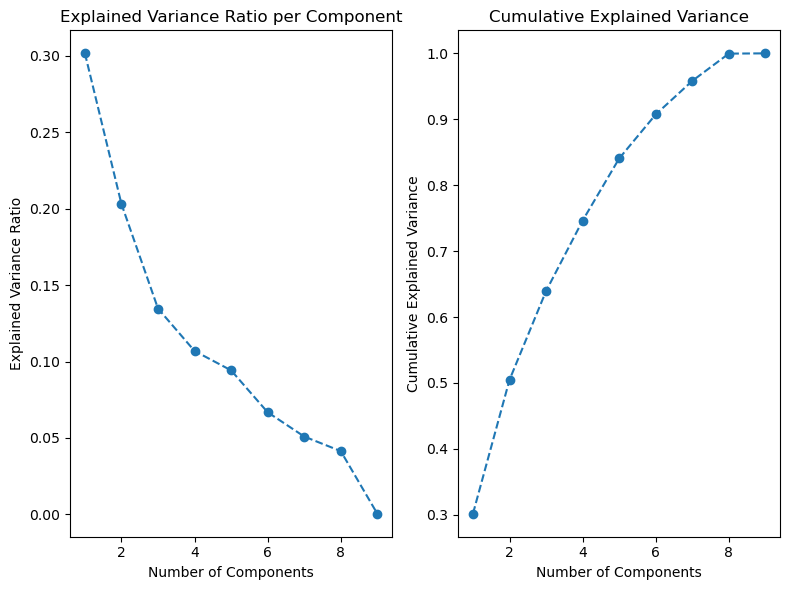

In [114]:
features_to_reduce_dev = df_dev[['e0', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8']]
features_to_reduce_eval = df_eval[['e0', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8']]

df_dev_reduced = df_dev.drop(columns=['e0', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8'])
df_eval_reduced = df_eval.drop(columns=['e0', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8'])

scaler = StandardScaler()
X_dev_scaled = scaler.fit_transform(features_to_reduce_dev)
X_eval_scaled = scaler.transform(features_to_reduce_eval)   # only transform


# ******************************************************************************************
pca = PCA()
pca.fit(X_dev_scaled)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance Ratio per Component')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

plt.tight_layout()
plt.show()
# **********************************************************************************************


pca = PCA(n_components=6) 
X_dev_pca = pca.fit_transform(X_dev_scaled)
X_eval_pca = pca.transform(X_eval_scaled)      # only transform


pca_columns = [f'PCA_e{i+1}' for i in range(X_dev_pca.shape[1])]
df_dev_pca = pd.DataFrame(X_dev_pca, columns=pca_columns, index=features_to_reduce_dev.index)    
df_eval_pca = pd.DataFrame(X_eval_pca, columns=pca_columns, index=features_to_reduce_eval.index)
df_dev_e = pd.concat([df_dev_reduced, df_dev_pca], axis=1)
df_eval_e = pd.concat([df_eval_reduced, df_eval_pca], axis=1)

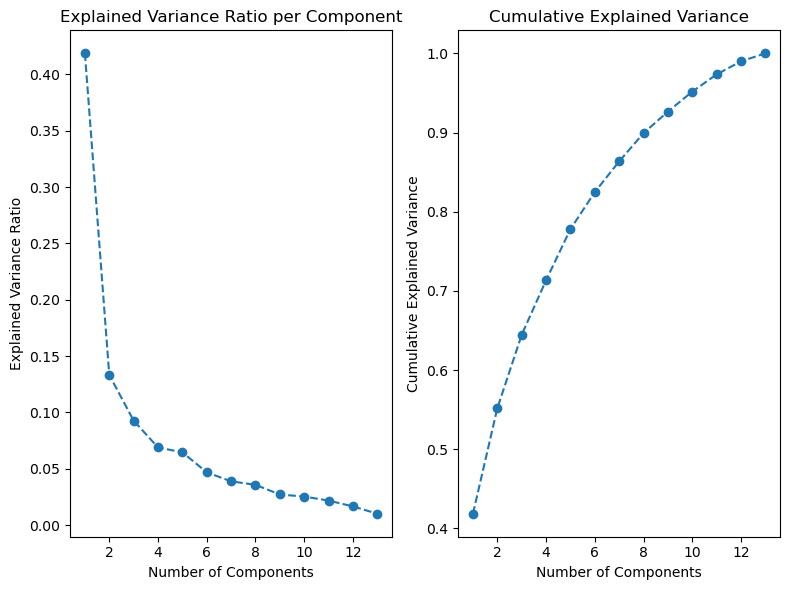

In [115]:
features_to_reduce_dev = df_dev[['mfcc_mean_0','mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 'mfcc_mean_8', 'mfcc_mean_9', 'mfcc_mean_10', 'mfcc_mean_11', 'mfcc_mean_12']]
features_to_reduce_eval = df_eval[['mfcc_mean_0','mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 'mfcc_mean_8', 'mfcc_mean_9', 'mfcc_mean_10', 'mfcc_mean_11', 'mfcc_mean_12']]

# Drop prom the previous dataframe
df_dev_reduced = df_dev_e.drop(columns=['mfcc_mean_0','mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 'mfcc_mean_8', 'mfcc_mean_9', 'mfcc_mean_10', 'mfcc_mean_11', 'mfcc_mean_12'])
df_eval_reduced = df_eval_e.drop(columns=['mfcc_mean_0','mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 'mfcc_mean_8', 'mfcc_mean_9', 'mfcc_mean_10', 'mfcc_mean_11', 'mfcc_mean_12'])

scaler = StandardScaler()
X_dev_scaled = scaler.fit_transform(features_to_reduce_dev)
X_eval_scaled = scaler.transform(features_to_reduce_eval)   # only transform


# ******************************************************************************************
pca = PCA()
pca.fit(X_dev_scaled)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance Ratio per Component')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

plt.tight_layout()
plt.show()
# **********************************************************************************************



pca = PCA(n_components=8) 
X_dev_pca = pca.fit_transform(X_dev_scaled)
X_eval_pca = pca.transform(X_eval_scaled)      # only transform


pca_columns = [f'PCA_mfcc{i+1}' for i in range(X_dev_pca.shape[1])]
df_dev_pca = pd.DataFrame(X_dev_pca, columns=pca_columns, index=features_to_reduce_dev.index)
df_eval_pca = pd.DataFrame(X_eval_pca, columns=pca_columns, index=features_to_reduce_eval.index)
df_dev_em = pd.concat([df_dev_reduced, df_dev_pca], axis=1)
df_eval_em = pd.concat([df_eval_reduced, df_eval_pca], axis=1)

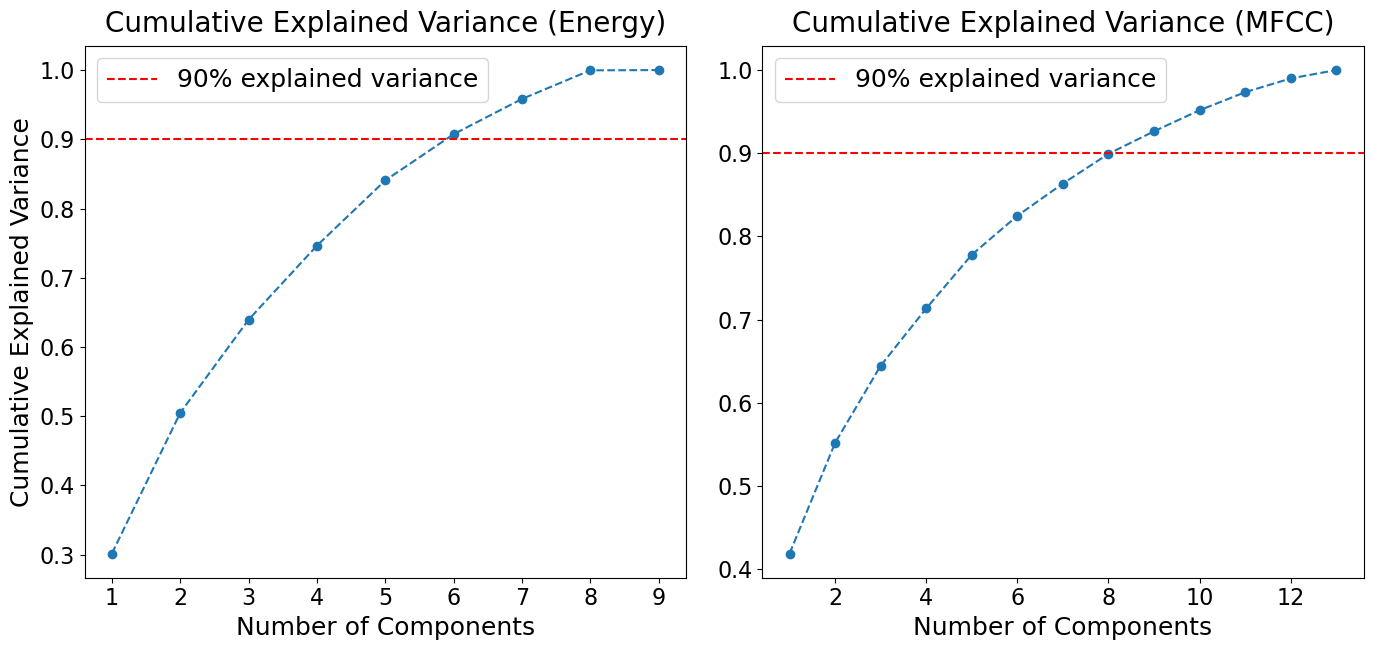

In [116]:
features_to_reduce_dev = df_dev[['e0', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8']]
features_to_reduce_eval = df_eval[['e0', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8']]
df_dev_reduced = df_dev.drop(columns=['e0', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8'])
df_eval_reduced = df_eval.drop(columns=['e0', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8'])

scaler = StandardScaler()
X_dev_scaled = scaler.fit_transform(features_to_reduce_dev)
X_eval_scaled = scaler.transform(features_to_reduce_eval)

pca = PCA()
pca.fit(X_dev_scaled)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

features_to_reduce_dev = df_dev[['mfcc_mean_0', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 
                                 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 'mfcc_mean_8', 'mfcc_mean_9', 
                                 'mfcc_mean_10', 'mfcc_mean_11', 'mfcc_mean_12']]
features_to_reduce_eval = df_eval[['mfcc_mean_0', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 
                                   'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 'mfcc_mean_8', 'mfcc_mean_9', 
                                   'mfcc_mean_10', 'mfcc_mean_11', 'mfcc_mean_12']]

df_dev_reduced = df_dev.drop(columns=['mfcc_mean_0', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 
                                      'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 'mfcc_mean_8', 'mfcc_mean_9', 
                                      'mfcc_mean_10', 'mfcc_mean_11', 'mfcc_mean_12'])
df_eval_reduced = df_eval.drop(columns=['mfcc_mean_0', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 
                                        'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 'mfcc_mean_8', 'mfcc_mean_9', 
                                        'mfcc_mean_10', 'mfcc_mean_11', 'mfcc_mean_12'])

scaler = StandardScaler()
X_dev_scaled = scaler.fit_transform(features_to_reduce_dev)
X_eval_scaled = scaler.transform(features_to_reduce_eval)

pca = PCA()
pca.fit(X_dev_scaled)
explained_variance_mfcc = pca.explained_variance_ratio_
cumulative_variance_mfcc = explained_variance_mfcc.cumsum()

plt.figure(figsize=(14, 6.6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance (Energy)', fontsize=20, pad = 10)
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Cumulative Explained Variance', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axhline(y=0.9, color='red', linestyle='--', label="90% explained variance")
plt.legend(fontsize=18)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance_mfcc) + 1), cumulative_variance_mfcc, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance (MFCC)', fontsize=20, pad = 10)
plt.xlabel('Number of Components', fontsize=18)
#plt.ylabel('Cumulative Explained Variance', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axhline(y=0.9, color='red', linestyle='--', label="90% explained variance")
plt.legend(fontsize=18)

plt.subplots_adjust(wspace=0.8)
plt.tight_layout()
plt.show()

# Data cleaning

In [118]:
# df_dev.pop('hnr')
# df_eval.pop('hnr');

# df_dev.pop('d0')
# df_eval.pop('d0')
# df_dev.pop('d1')
# df_eval.pop('d1')
# df_dev.pop('d3')
# df_eval.pop('d3')
# df_dev.pop('d4')
# df_eval.pop('d4');

# df_dev = df_dev.drop(columns=[f'mfcc_mean_{i}' for i in range(13)], axis=1)
# df_eval = df_eval.drop(columns=[f'mfcc_mean_{i}' for i in range(13)], axis=1)

# Outlier detection with DBSCAN

In [25]:
# df_dev.info()

In [3]:
## Without new features     # BEST PERFORMING SO FAR
# df_dev = pd.read_csv('df_dev_eth_noc.csv',  index_col=0)
# df_eval = pd.read_csv('df_eval_eth_noc.csv',  index_col=0)
# y_dev = pd.read_csv('y_dev.csv',  index_col=0)

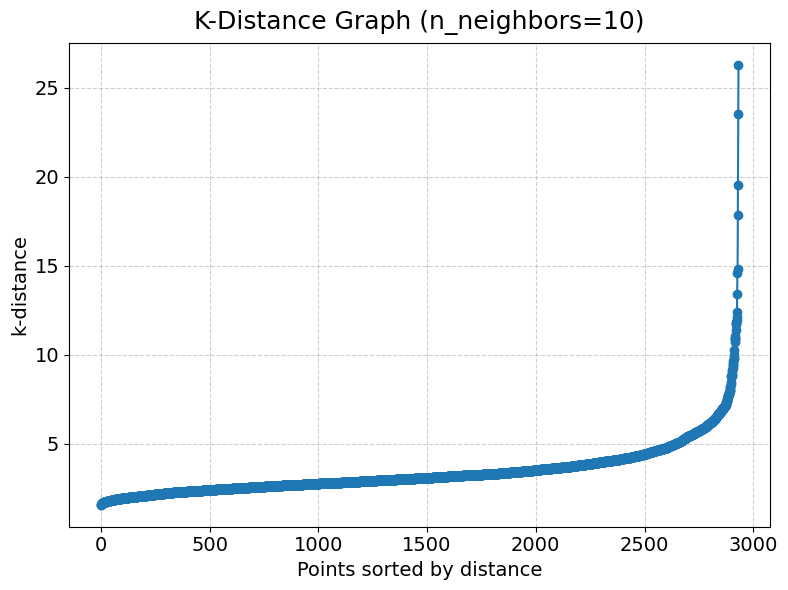

In [4]:
data = df_dev.copy()
data.drop(columns=["Western", "SubSaharian", "Asian", "Others", "gender"], inplace=True)
 
data = (data - data.mean()) / data.std()

'''
data["Western"] = df_dev["Western"]
data["SubSaharian"] = df_dev["SubSaharian"]
data["Asian"] = df_dev["Asian"]
data["Others"] = df_dev["Others"]
data["gender"] = df_dev["gender"]
'''


neigh = NearestNeighbors(n_neighbors=10)  # min_samples=4, so k=4-1=3
nbrs = neigh.fit(data)
distances, indices = nbrs.kneighbors(data)

distances = np.sort(distances[:, -1])
plt.figure(figsize=(8, 6))
plt.plot(distances, marker='o')
plt.title("K-Distance Graph (n_neighbors=10)", fontsize=18, pad = 10)
plt.xlabel("Points sorted by distance", fontsize=14)
plt.ylabel("k-distance", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

Processing the interval: 0-100
Number of samples in the interval 0-100: 2933


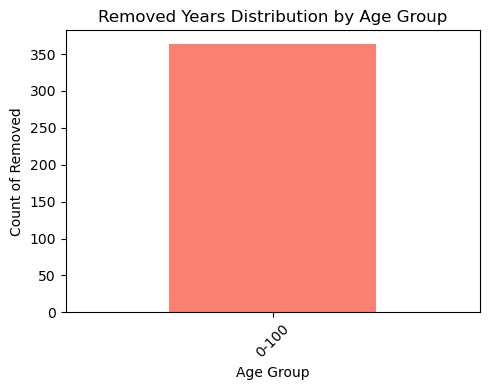

In [5]:
data = df_dev.copy()
data_eval= df_eval.copy() 
y = y_dev.copy()
data.drop(columns=["Western", "SubSaharian", "Asian", "Others", "gender"], inplace=True)
data_eval.drop(columns=["Western", "SubSaharian", "Asian", "Others", "gender"], inplace=True)

mean = data.mean()
std = data.std()
data = (data - mean) / std
data_eval = (data_eval - mean) / std               #USING DEVELOPMENT DATA!!!

data[["Western", "SubSaharian", "Asian", "Others", "gender"]] = df_dev[["Western", "SubSaharian", "Asian", "Others", "gender"]]
data_eval[["Western", "SubSaharian", "Asian", "Others", "gender"]] = df_eval[["Western", "SubSaharian", "Asian", "Others", "gender"]]

def split_by_age(df, age_column='age'):
    age_intervals = [(0,100)]#[(0, 20), (20, 30), (30, 40), (40, 50), (50, 70), (70, 100)]
    
    df_list = []

    for start_age, end_age in age_intervals:
        print(f"Processing the interval: {start_age}-{end_age}") 
        mask = (df[age_column] >= start_age) & (df[age_column] < end_age)
        if mask.any():  
            data_group = df[mask].copy()  
            print(f"Number of samples in the interval {start_age}-{end_age}: {data_group.shape[0]}")
            df_list.append(data_group)
        else:
            print(f"No data in the interval {start_age}-{end_age}.")

    return df_list




def remove_outliers_with_dbscan_from_list(df_list, target_column='age', eps=5, min_samples=3):
 
    cleaned_dfs = []
    removed_targets = []   # <-----

    for i, df in enumerate(df_list):
        data = df.drop(columns=[target_column])
        target = df[target_column]

        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(data)

        # Identify the outliers
        mask = dbscan.labels_ != -1
        removed_targets.extend(target[~mask].tolist()) # <-----
        removed_years = pd.Series(removed_targets, name="age")    # <-----
        
        #************************************************************************************
        l = len(df_list)
        if i == l-1: # At the end we plot the plot
            # Define the bins and labels
            bins = [0,100]#[0, 20, 30, 40, 50, 70, 100]
            labels = ['0-100']#['0-20', '20-30', '30-40', '40-50', '50-70', '70-100']

            removed_years_grouped = pd.cut(removed_years, bins=bins, labels=labels, right=False)
            removed_age_group_counts = removed_years_grouped.value_counts().sort_index()

            # Plot the result as a bar plot
            plt.figure(figsize=(5, 4))
            removed_age_group_counts.plot(kind='bar', color='salmon')
            plt.title('Removed Years Distribution by Age Group')
            plt.xlabel('Age Group')
            plt.ylabel('Count of Removed')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        #************************************************************************************
        
        data_clean = data[mask]
        target_clean = target[mask]

        df_clean = pd.concat([data_clean, target_clean], axis=1)
        cleaned_dfs.append(df_clean)

        # print(f"DataFrame {i}: N° of remove outliers: {sum(~mask)}") <-----
        # print("Removed years:", removed_targets)    # <-----

    return cleaned_dfs

# Step 1: Split the dataset by age intervals
# Lists to store the dataframes and y Series separately
X_list = []
y_list = []

data["age"] = y
dataframe_list = split_by_age(data, age_column='age') 
target_column = 'age'


# Step 2: DBSCAN for outlier removal
data =  remove_outliers_with_dbscan_from_list(dataframe_list, target_column, eps=3.95, min_samples=10)   # 3.95 o 4.2, and 10

data = pd.concat(data, axis=0, ignore_index=True)
 
df_shuffled = shuffle(data, random_state=42).reset_index(drop=True)

y_dev_final_all = df_shuffled['age']
df_dev_final_all = df_shuffled.drop(columns=['age'])

In [6]:
df_dev_final_all.shape

(2569, 42)

Processando intervallo: 0-20
Numero di esempi nell'intervallo 0-20: 834
Processando intervallo: 20-30
Numero di esempi nell'intervallo 20-30: 1251
Processando intervallo: 30-40
Numero di esempi nell'intervallo 30-40: 376
Processando intervallo: 40-50
Numero di esempi nell'intervallo 40-50: 204
Processando intervallo: 50-70
Numero di esempi nell'intervallo 50-70: 223
Processando intervallo: 70-100
Numero di esempi nell'intervallo 70-100: 45


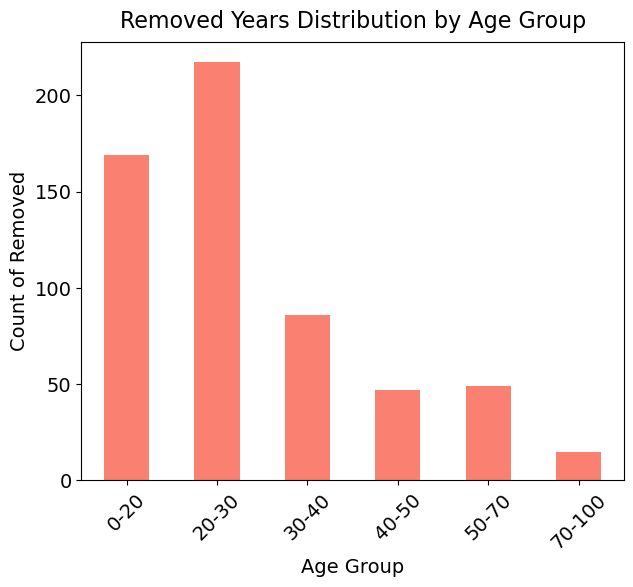

In [7]:
data = df_dev.copy()
data_eval= df_eval.copy() 
y = y_dev.copy()
data.drop(columns=["Western", "SubSaharian", "Asian", "Others", "gender"], inplace=True)
data_eval.drop(columns=["Western", "SubSaharian", "Asian", "Others", "gender"], inplace=True)

mean = data.mean()
std = data.std()
data = (data - mean) / std
data_eval = (data_eval - mean) / std               #USING DEVELOPMENT DATA!!!

data[["Western", "SubSaharian", "Asian", "Others", "gender"]] = df_dev[["Western", "SubSaharian", "Asian", "Others", "gender"]]
data_eval[["Western", "SubSaharian", "Asian", "Others", "gender"]] = df_eval[["Western", "SubSaharian", "Asian", "Others", "gender"]]

def split_by_age(df, age_column='age'):
    # Fixed age intervals
    age_intervals = [(0, 20), (20, 30), (30, 40), (40, 50), (50, 70), (70, 100)]
    df_list = []

    # Itarate over the different interval ages
    for start_age, end_age in age_intervals:
        print(f"Processando intervallo: {start_age}-{end_age}")  # Debug: mostra l'intervallo    
        mask = (df[age_column] >= start_age) & (df[age_column] < end_age)
 
        if mask.any():  
            data_group = df[mask].copy() 
            print(f"Numero di esempi nell'intervallo {start_age}-{end_age}: {data_group.shape[0]}")
            df_list.append(data_group)
        else:
            print(f"Nessun dato nell'intervallo {start_age}-{end_age}.")
    
    return df_list



def remove_outliers_with_dbscan_from_list(df_list, target_column='age', eps=5, min_samples=3):
 
    cleaned_dfs = []  # List for clean dataframes
    removed_targets = []   # <-----

    for i, df in enumerate(df_list):
        data = df.drop(columns=[target_column])
        target = df[target_column]

        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(data)

        # Identify the outliers
        mask = dbscan.labels_ != -1
        removed_targets.extend(target[~mask].tolist()) # <-----
        removed_years = pd.Series(removed_targets, name="age")    # <-----
        
        #************************************************************************************
        l = len(df_list)
        if i == l-1: # At the end we plot the plot
            # Define the bins and labels
            bins = [0, 20, 30, 40, 50, 70, 100]
            labels = ['0-20', '20-30', '30-40', '40-50', '50-70', '70-100']

            removed_years_grouped = pd.cut(removed_years, bins=bins, labels=labels, right=False)
            removed_age_group_counts = removed_years_grouped.value_counts().sort_index()

            # Plot the result as a bar plot
            plt.figure(figsize=(7, 5.7))
            removed_age_group_counts.plot(kind='bar', color='salmon')
            plt.title('Removed Years Distribution by Age Group', fontsize=16, pad = 10)
            plt.xlabel('Age Group')
            plt.ylabel('Count of Removed')
            plt.xlabel('Age Group', fontsize=14)
            plt.ylabel('Count of Removed', fontsize=14)
            plt.xticks(rotation=45, fontsize=14)
            plt.yticks(fontsize=14)
            plt.show()
        #************************************************************************************

        data_clean = data[mask]
        target_clean = target[mask]
        df_clean = pd.concat([data_clean, target_clean], axis=1)
        cleaned_dfs.append(df_clean)

        # print(f"DataFrame {i}: N° of remove outliers: {sum(~mask)}") <-----
        # print("Removed years:", removed_targets)    # <-----

    return cleaned_dfs

# Step 1: Split the dataset by age intervals
# Lists to store the dataframes and y Series separately
X_list = []
y_list = []

data["age"] = y
dataframe_list = split_by_age(data, age_column='age') 
target_column = 'age'


# Step 2: DBSCAN for outlier removal
data =  remove_outliers_with_dbscan_from_list(dataframe_list, target_column, eps=3.95, min_samples=10)   # 3.95 o 4.2, and 10

data = pd.concat(data, axis=0, ignore_index=True)
 
df_shuffled = shuffle(data, random_state=42).reset_index(drop=True)

y_dev_final = df_shuffled['age']
df_dev_final = df_shuffled.drop(columns=['age'])
df_eval_final = data_eval.copy()

In [8]:
df_dev_final.shape

(2350, 42)

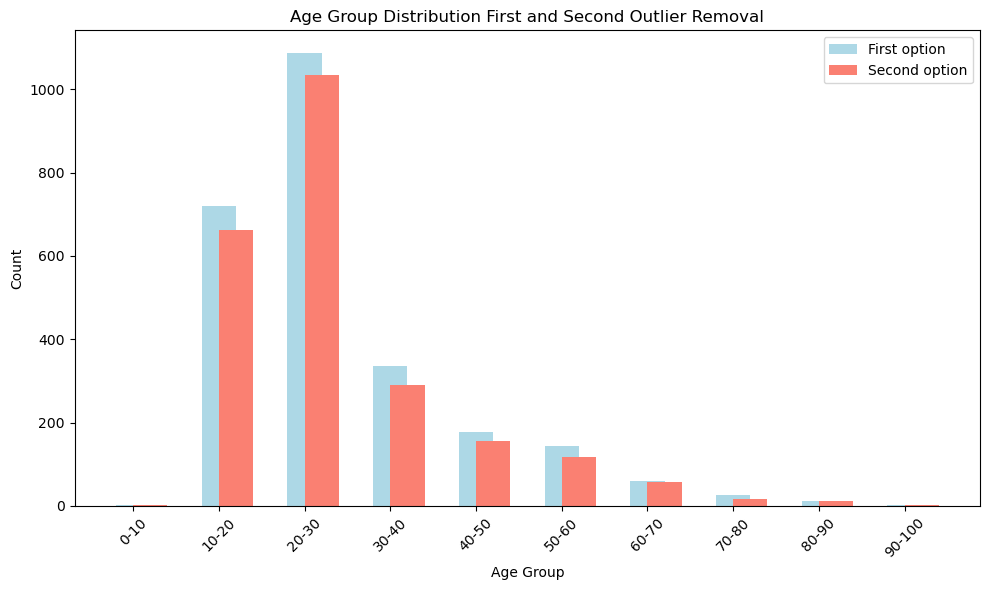

In [9]:
# bins = [0, 20, 30, 40, 50, 70, 100]
# labels = ['0-20', '20-30', '30-40', '40-50', '50-70', '70-100']

bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']



def get_age_group_counts(target, bins=bins, labels=labels):
    # Categorize the target values (ages) into bins
    age_groups = pd.cut(target, bins=bins, labels=labels, right=False)
    return age_groups.value_counts().sort_index()

df_dev_final_all_counts = get_age_group_counts(y_dev_final_all)   #First option  
df_dev_final_counts = get_age_group_counts(y_dev_final)  #Second option

plt.figure(figsize=(10, 6))
plt.bar(df_dev_final_all_counts.index, df_dev_final_all_counts.values, width=0.4, label='First option', align='center', color='lightblue')
plt.bar(df_dev_final_counts.index, df_dev_final_counts.values, width=0.4, label='Second option', align='edge', color='salmon')

plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Group Distribution First and Second Outlier Removal')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Hyperparameter tuning

In [10]:
def evaluation_metric_RMSE(y, y_pred):
    '''
    y : true values (1D)
    y_pred : predicted values (1D)
    '''
    l = y.shape[0]
    squared_error_sum = np.sum((y - y_pred) ** 2)
    rmse = np.sqrt(squared_error_sum / l)
    return rmse

In [11]:
custom_scorer = make_scorer(evaluation_metric_RMSE, greater_is_better=False)

### Results Grid Search

### Random forest

In [330]:
params = {
    "n_estimators": [1000],
    "criterion": ['squared_error'],
    "max_depth": [20, 23, 25],
    "min_samples_split": [5, 7, 10],
    "min_samples_leaf": [5, 7, 10],
    "min_weight_fraction_leaf": [0.0],
    "max_features": ["sqrt"],
    "max_leaf_nodes": [200, 150],
    "min_impurity_decrease": [0.01, 0.015],
    "bootstrap": [True],
    "oob_score": [True],
    "n_jobs": [-1],
    "random_state": [23],
    "verbose": [1],
    "ccp_alpha": [0.0],
    "max_samples": [0.9, 0.85]
}


reg = RandomForestRegressor()
gridsearch = GridSearchCV(reg, params, scoring=custom_scorer, cv = 3, n_jobs = -1, verbose = 1)
gridsearch.fit(df_dev_final, y_dev_final)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.6s finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'ccp_alpha': [0.0],
                         'criterion': ['squared_error'],
                         'max_depth': [20, 23, 25], 'max_features': ['sqrt'],
                         'max_leaf_nodes': [200, 150],
                         'max_samples': [0.9, 0.85],
                         'min_impurity_decrease': [0.01, 0.015],
                         'min_samples_leaf': [5, 7, 10],
                         'min_samples_split': [5, 7, 10],
                         'min_weight_fraction_leaf': [0.0],
                         'n_estimators': [1000], 'n_jobs': [-1],
                         'oob_score': [True], 'random_state': [23],
                         'verbose': [1]},
             scoring=make_scorer(evaluation_metric_RMSE, greater_is_better=False),
             verbose=1)

In [331]:
print(gridsearch.best_params_)
print('\nResult:\n', gridsearch.best_score_)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': 200, 'max_samples': 0.9, 'min_impurity_decrease': 0.015, 'min_samples_leaf': 5, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': -1, 'oob_score': True, 'random_state': 23, 'verbose': 1}

Result:
 -10.05836526767952


### SVR
To diminish the features space we remove some features. 

In [242]:
# df_dev_final.info()

In [12]:
# df_dev_final.pop('skewness')
# df_eval_final.pop('skewness');

# df_dev_final.pop('num_characters')
# df_eval_final.pop('num_characters');

# df_dev_final.pop('num_pauses')
# df_eval_final.pop('num_pauses');


# df_dev.pop('d0')
# df_eval.pop('d0')
# df_dev.pop('d1')
# df_eval.pop('d1')
# df_dev.pop('d3')
# df_eval.pop('d3')
# df_dev.pop('d4')
# df_eval.pop('d4');

In [24]:
# df_dev_final.info()

In [14]:
params_svm = {
    'kernel': ['poly', 'rbf', 'sigmoid'], 
    'C': [1, 10, 20],  # Regularization parameter
    'epsilon': [0.1, 0.2],  
    'degree': [1],  # for 'poly' kernel
    'gamma': ['scale', 'auto'],  # for 'rbf', 'poly', 'sigmoid'
    'max_iter': [3000, 5000],
    'tol': [1e-3, 1e-5],  
    'shrinking': [True, False],  
    'coef0': [0],  
}

svm_reg = SVR()
gridsearch_svm = GridSearchCV(svm_reg, params_svm, scoring=custom_scorer, cv=3, n_jobs=-1, verbose=1)
gridsearch_svm.fit(df_dev_final, y_dev_final)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


GridSearchCV(cv=3, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [1, 10, 20], 'coef0': [0], 'degree': [1],
                         'epsilon': [0.1, 0.2], 'gamma': ['scale', 'auto'],
                         'kernel': ['poly', 'rbf', 'sigmoid'],
                         'max_iter': [3000, 5000], 'shrinking': [True, False],
                         'tol': [0.001, 1e-05]},
             scoring=make_scorer(evaluation_metric_RMSE, greater_is_better=False),
             verbose=1)

In [15]:
print(gridsearch_svm.best_params_)
print('\nResult:\n', gridsearch_svm.best_score_)

{'C': 20, 'coef0': 0, 'degree': 1, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 5000, 'shrinking': True, 'tol': 0.001}

Result:
 -10.131759546648873


### Ridge and Lasso

In [16]:
params_ridge = {
    'alpha': [0.1, 1, 10, 20, 50],  # Regularization strength
    'solver': ['auto', 'svd', 'cholesky', 'lsqr'],  # Solver choice
    'tol': [1e-3, 1e-4, 1e-5],
    'max_iter': [2000, 5000],
    'fit_intercept': [True, False],
    'random_state': [23]
}

ridge_reg = Ridge()
gridsearch_ridge = GridSearchCV(ridge_reg, params_ridge, scoring=custom_scorer, cv=3, n_jobs=-1, verbose=1)
gridsearch_ridge.fit(df_dev_final, y_dev_final)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


GridSearchCV(cv=3, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.1, 1, 10, 20, 50],
                         'fit_intercept': [True, False],
                         'max_iter': [2000, 5000], 'random_state': [23],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr'],
                         'tol': [0.001, 0.0001, 1e-05]},
             scoring=make_scorer(evaluation_metric_RMSE, greater_is_better=False),
             verbose=1)

In [17]:
print(gridsearch_ridge.best_params_)
print('\nResult:\n', gridsearch_ridge.best_score_)

{'alpha': 20, 'fit_intercept': True, 'max_iter': 2000, 'random_state': 23, 'solver': 'lsqr', 'tol': 1e-05}

Result:
 -10.180354026218714


In [18]:
params_lasso = {
    'alpha': [0.01, 0.5, 0.1, 1],  # Regularization strength
    'max_iter': [5000, 10000],  
    'selection': ['cyclic', 'random'],  # Method for selecting coefficients
    'tol': [1e-3, 1e-4, 1e-5],
    'fit_intercept': [True, False],
    'random_state': [23]
}

lasso_reg = Lasso()
gridsearch_lasso = GridSearchCV(lasso_reg, params_lasso, scoring=custom_scorer, cv=3, n_jobs=-1, verbose=1)
gridsearch_lasso.fit(df_dev_final, y_dev_final)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


GridSearchCV(cv=3, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.5, 0.1, 1],
                         'fit_intercept': [True, False],
                         'max_iter': [5000, 10000], 'random_state': [23],
                         'selection': ['cyclic', 'random'],
                         'tol': [0.001, 0.0001, 1e-05]},
             scoring=make_scorer(evaluation_metric_RMSE, greater_is_better=False),
             verbose=1)

In [19]:
print(gridsearch_lasso.best_params_)
print('\nResult:\n', gridsearch_lasso.best_score_)

{'alpha': 0.01, 'fit_intercept': False, 'max_iter': 5000, 'random_state': 23, 'selection': 'cyclic', 'tol': 1e-05}

Result:
 -10.18042792699087


### Results for the lederboard

In [20]:
# Best Random Forest model
best_rf_model = RandomForestRegressor(
    n_estimators=1000,
    max_features='sqrt',
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=5,
    max_leaf_nodes=200,
    min_impurity_decrease=0.015,
    bootstrap=True,
    max_samples=0.9,
    oob_score=True,
    n_jobs=-1,
    random_state=23,
    criterion='squared_error'
)

# Best SVM model
best_svm_model = SVR(
    C=20,
    kernel='rbf',
    degree=1,
    epsilon=0.2,
    gamma='scale',
    coef0=0,
    max_iter=3000,
    shrinking=False,
    tol=0.001
)

# Best Ridge Regression model
best_ridge_model = Ridge(
    alpha=20,
    fit_intercept=True,
    max_iter=2000,
    solver='lsqr',
    tol=1e-05,
    random_state=23
)

# Best Lasso Regression model
best_lasso_model = Lasso(
    alpha=0.01,
    fit_intercept=False,
    max_iter=5000,
    selection='random',
    tol=0.0001,
    random_state=23
)


In [22]:
y_dev_final.squeeze();

best_svm_model.fit(df_dev_final, y_dev_final)
y_pred = best_svm_model.predict(df_eval_final)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [23]:
submission = pd.DataFrame({
    'Id': range(len(y_pred)),  
    'Predicted': y_pred                  
})
submission.to_csv('submission_SVR.csv', index=False)

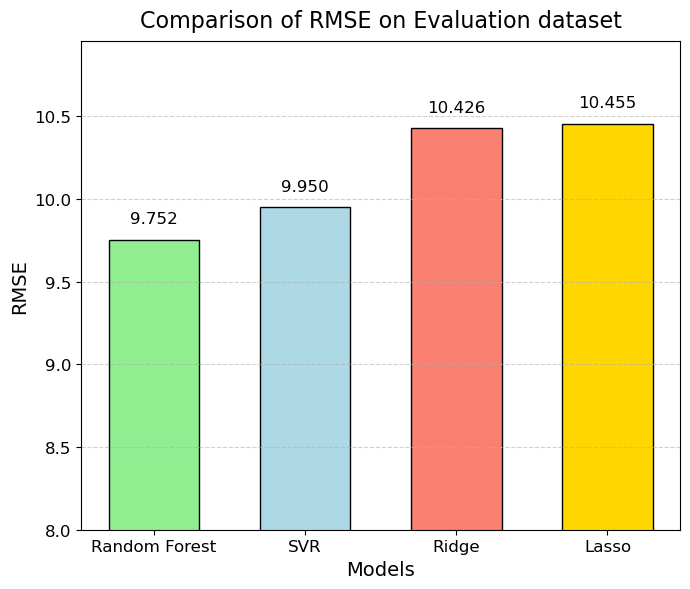

In [435]:
models = ['Random Forest', 'SVR', 'Ridge', 'Lasso']
rmse_values = [9.752, 9.950, 10.426, 10.455]

plt.figure(figsize=(7, 6))
bars = plt.bar(models, rmse_values, color=['lightgreen', 'lightblue', 'salmon', 'gold'], edgecolor='black', width=0.6)

for bar, value in zip(bars, rmse_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, f'{value:.3f}', 
             ha='center', fontsize=12)

plt.title('Comparison of RMSE on Evaluation dataset', fontsize=16, pad=10)
plt.xlabel('Models', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.ylim(8, max(rmse_values) + 0.5)
plt.tight_layout()

plt.show()

RF: 9.752  <br>
SVR: 9.950   <br>
Ridge: 10.426    <br>
Lasso: 10.455     <br>

# Final model

In [432]:
# Best Random Forest model
final_rf_model = RandomForestRegressor(
    n_estimators=5000,
    max_features='sqrt',
    max_depth=23,
    min_samples_split=5,
    min_samples_leaf=5,
    max_leaf_nodes=200,
    min_impurity_decrease=0.015,
    bootstrap=True,
    max_samples=0.9,
    oob_score=True,
    n_jobs=-1,
    random_state=23,
    criterion='squared_error'
)

In [433]:
y_dev_final.squeeze();

final_rf_model.fit(df_dev_final, y_dev_final)
y_pred = final_rf_model.predict(df_eval_final)

In [434]:
submission = pd.DataFrame({
    'Id': range(len(y_pred)),  
    'Predicted': y_pred                  
})
submission.to_csv('submission_final_BEST.csv', index=False)